> Imports 

In [3]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, ElasticNet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler




Follwing Forcasting Princioples and practices 

- step 1. Tidy data was done in the previous notebook (her_DataExploratie.ipynb)
- step 2. Datavisualisation. will be done in this notebook(after the split)
- step 3. Defining model
- Step 4 Train the model (estimate/fit) 
- Step 5. Evaluate the model
- Forcast generation

In [4]:
# Load data
df = pd.read_csv(r"C:\Users\dylan\OneDrive - HvA\AAI Master\BLOK 3 afstuderen\Thesis\Eigenwerk\DATASET\AVG_Gas.csv")
df["Time Period (T)"] = pd.to_datetime(df["Time Period (T)"], format="%Y-%m-%d")
df = df.sort_values("Time Period (T)").reset_index(drop=True)


 Sliding Window Cross-Validation (Fixed Window)

In [3]:

def strict_expanding_window_validation(
    df, features, target_col, model_fn, forecast_horizon=3
):
    n = len(df)
    test_start = int(n * 0.85)
    val_start = int(n * 0.75)

    X = df[features].values
    y = df[target_col].values

    val_preds, val_actuals, val_dates = [], [], []
    for i in range(val_start, test_start - forecast_horizon + 1):
        X_train = X[:i]
        y_train = y[:i]
        X_val = X[i:i+forecast_horizon]
        y_val = y[i:i+forecast_horizon]

        model = model_fn()
        model.fit(X_train, y_train)
        preds = model.predict(X_val)

        val_preds.extend(preds)
        val_actuals.extend(y_val)
        val_dates.extend(df.iloc[i:i+forecast_horizon]['Periode'].values)

    test_preds, test_actuals, test_dates = [], [], []
    for i in range(test_start, n - forecast_horizon + 1):
        X_train = X[:i]
        y_train = y[:i]
        X_test = X[i:i+forecast_horizon]
        y_test = y[i:i+forecast_horizon]

        model = model_fn()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        test_preds.extend(preds)
        test_actuals.extend(y_test)
        test_dates.extend(df.iloc[i:i+forecast_horizon]['Periode'].values)

    return {
        "val_mae": mean_absolute_error(val_actuals, val_preds),
        "val_rmse": np.sqrt(mean_squared_error(val_actuals, val_preds)),
        "val_r2": r2_score(val_actuals, val_preds),
        "val_mape": mean_absolute_percentage_error(val_actuals, val_preds),
        "val_preds": np.array(val_preds),
        "val_actuals": np.array(val_actuals),
        "val_dates": np.array(val_dates),
        "test_mae": mean_absolute_error(test_actuals, test_preds),
        "test_rmse": np.sqrt(mean_squared_error(test_actuals, test_preds)),
        "test_r2": r2_score(test_actuals, test_preds),
        "test_mape": mean_absolute_percentage_error(test_actuals, test_preds),
        "test_preds": np.array(test_preds),
        "test_actuals": np.array(test_actuals),
        "test_dates": np.array(test_dates)
    }
    

Train size: 162
Validation size: 22
Test size: 33
Train period: 2007-01-01 00:00:00 to 2020-06-01 00:00:00
Validation period: 2020-07-01 00:00:00 to 2022-04-01 00:00:00
Test period: 2022-05-01 00:00:00 to 2025-01-01 00:00:00


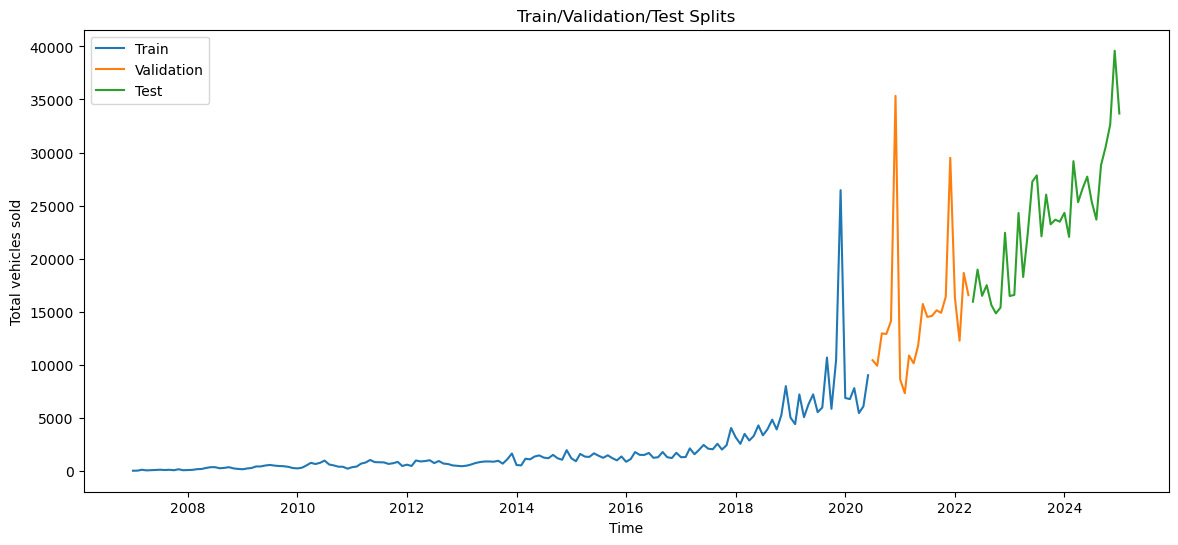

In [4]:
# Calculate train, validation, and test indices
n = len(df)
test_start = int(n * 0.85)
val_start = int(n * 0.75)

train_idx = np.arange(0, val_start)
val_idx = np.arange(val_start, test_start)
test_idx = np.arange(test_start, n)

# Print sizes
print(f"Train size: {len(train_idx)}")
print(f"Validation size: {len(val_idx)}")
print(f"Test size: {len(test_idx)}")

# Print first and last date for each split
print(f"Train period: {df.iloc[train_idx[0]]['Time Period (T)']} to {df.iloc[train_idx[-1]]['Time Period (T)']}")
print(f"Validation period: {df.iloc[val_idx[0]]['Time Period (T)']} to {df.iloc[val_idx[-1]]['Time Period (T)']}")
print(f"Test period: {df.iloc[test_idx[0]]['Time Period (T)']} to {df.iloc[test_idx[-1]]['Time Period (T)']}")

# Plot splits
plt.figure(figsize=(14, 6))
plt.plot(df.loc[train_idx, "Time Period (T)"], df.loc[train_idx, "Total vehicles sold (Target)"], label="Train")
plt.plot(df.loc[val_idx, "Time Period (T)"], df.loc[val_idx, "Total vehicles sold (Target)"], label="Validation")
plt.plot(df.loc[test_idx, "Time Period (T)"], df.loc[test_idx, "Total vehicles sold (Target)"], label="Test")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold")
plt.title("Train/Validation/Test Splits")
plt.legend()
plt.show()

looking at the data we see a couple of things:
- The data is not stationary, it has a trend and seasonality.
- The data has sharp spikes and wide variance (especially post-2020)

Log-transformed would give the data a more consistent fluctuation and reduced volatility, to determan the optimal lamda value for the log transformation, I will use the Box-Cox transformation. This transformation is useful for stabilizing variance and making the data more normally distributed.


Optimal lambda for Box-Cox: -0.0021


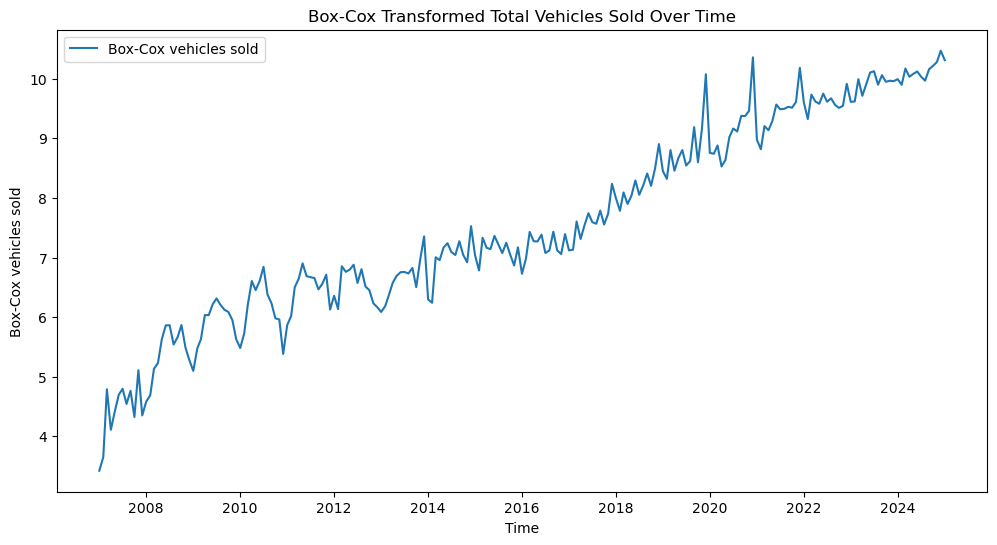

In [5]:
from scipy.stats import boxcox

# Select the target column
target_col = 'Total vehicles sold (Target)'
y = df[target_col].values

# Box-Cox requires all values > 0
if (y <= 0).any():
    raise ValueError("Box-Cox transformation requires all values to be positive.")

# Perform Box-Cox transformation
y_boxcox, fitted_lambda = boxcox(y)

# Add transformed values to the dataframe
df['BoxCox vehicles sold (Target)'] = y_boxcox

print(f"Optimal lambda for Box-Cox: {fitted_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], y_boxcox, label="Box-Cox vehicles sold")
plt.xlabel("Time")
plt.ylabel("Box-Cox vehicles sold")
plt.title("Box-Cox Transformed Total Vehicles Sold Over Time")
plt.legend()
plt.show()

In [ ]:
# Create a copy of the target column and apply the log function
df['Log vehicles sold (Target)'] = target_log

In [6]:
display(df.head())


Time Period (T)  Home charging (G)  Electric car (G)  Hybrid electric (G)  \
0      2007-01-01                  0                 1                    0   
1      2007-02-01                  0                 0                    0   
2      2007-03-01                  0                 0                    0   
3      2007-04-01                  0                 0                    0   
4      2007-05-01                  0                 2                    0   

   Company car tax rate (%)  Consumer confidence (E)  \
0                        22                     20.0   
1                        22                     20.0   
2                        22                     20.0   
3                        22                     20.0   
4                        22                     18.0   

   Economic climate perception (E)  Willingness to buy (E)  \
0                             37.0                     9.0   
1                             37.0                     9.0   
2                             37.0                     9.0   
3                             37.0                     9.0   
4                             32.0                     9.0   

   Major purchases sentiment (E)  Gasoline (Euro95) - Average price (F)  \
0                            8.0                               1.303032   
1                            8.0                               1.325357   
2                            8.0                               1.379032   
3                            8.0                               1.426500   
4                            7.4                               1.466516   

   Diesel - Average price (F)  Total vehicles sold (Target)  \
0                    0.970000                            31   
1                    0.990000                            39   
2                    1.006323                           123   
3                    1.030600                            62   
4                    1.032323                            84   

   BoxCox vehicles sold (Target)  
0                       3.421755  
1                       3.649641  
2                       4.788185  
3                       4.109473  
4                       4.410465

In [7]:
from ipywidgets import interact, FloatSlider
from scipy.special import boxcox1p

def plot_boxcox_lambda(lambda_val):
    # Box-Cox transformation with adjustable lambda
    if abs(lambda_val) < 1e-6:
        y_trans = np.log(df['Total vehicles sold (Target)'])
        ylabel = "Log vehicles sold"
    else:
        y_trans = (df['Total vehicles sold (Target)'] ** lambda_val - 1) / lambda_val
        ylabel = f"Box-Cox (λ={lambda_val:.2f}) vehicles sold"
    plt.figure(figsize=(12, 6))
    plt.plot(df["Time Period (T)"], y_trans, label=ylabel)
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    plt.title("Box-Cox/Log Transformed Total Vehicles Sold Over Time")
    plt.legend()
    plt.show()

interact(
    plot_boxcox_lambda,
    lambda_val=FloatSlider(
        value=fitted_lambda,
        min=-1.0,
        max=1.0,
        step=0.01,
        description='Lambda'
    )
)

interactive(children=(FloatSlider(value=-0.002079636725042893, description='Lambda', max=1.0, min=-1.0, step=0…

<function __main__.plot_boxcox_lambda(lambda_val)>

3.2 The decomposition helps isolate stable patterns (trend and seasonality), which can improve forecast accuracy and interpretability. It also highlights outliers in the residual component that may require special attention in model evaluation.

(Stl)  

<Figure size 1400x1000 with 0 Axes>

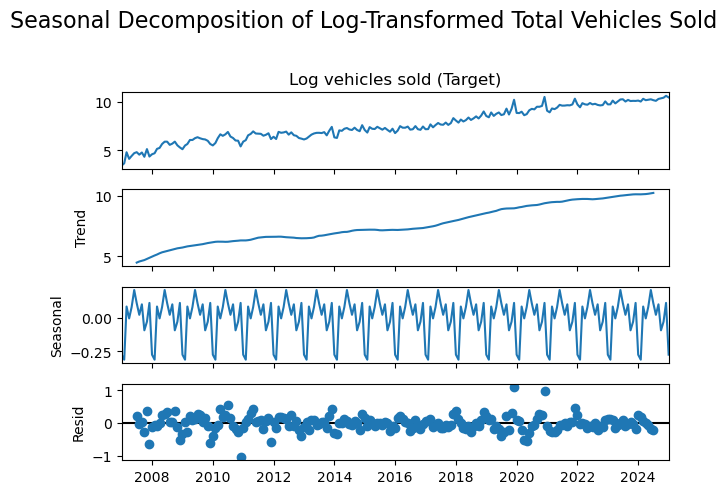

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Ensure the log-transformed column exists
if "Log vehicles sold (Target)" not in df.columns:
	df["Log vehicles sold (Target)"] = np.log1p(df["Total vehicles sold (Target)"])

# Use the log-transformed target series for decomposition
log_series = df.set_index("Time Period (T)")["Log vehicles sold (Target)"]

# Perform seasonal decomposition (monthly frequency)
log_decomposition = seasonal_decompose(log_series, model='additive', period=12)

# Plot the decomposition
plt.figure(figsize=(14, 10))
log_decomposition.plot()
plt.suptitle("Seasonal Decomposition of Log-Transformed Total Vehicles Sold", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()




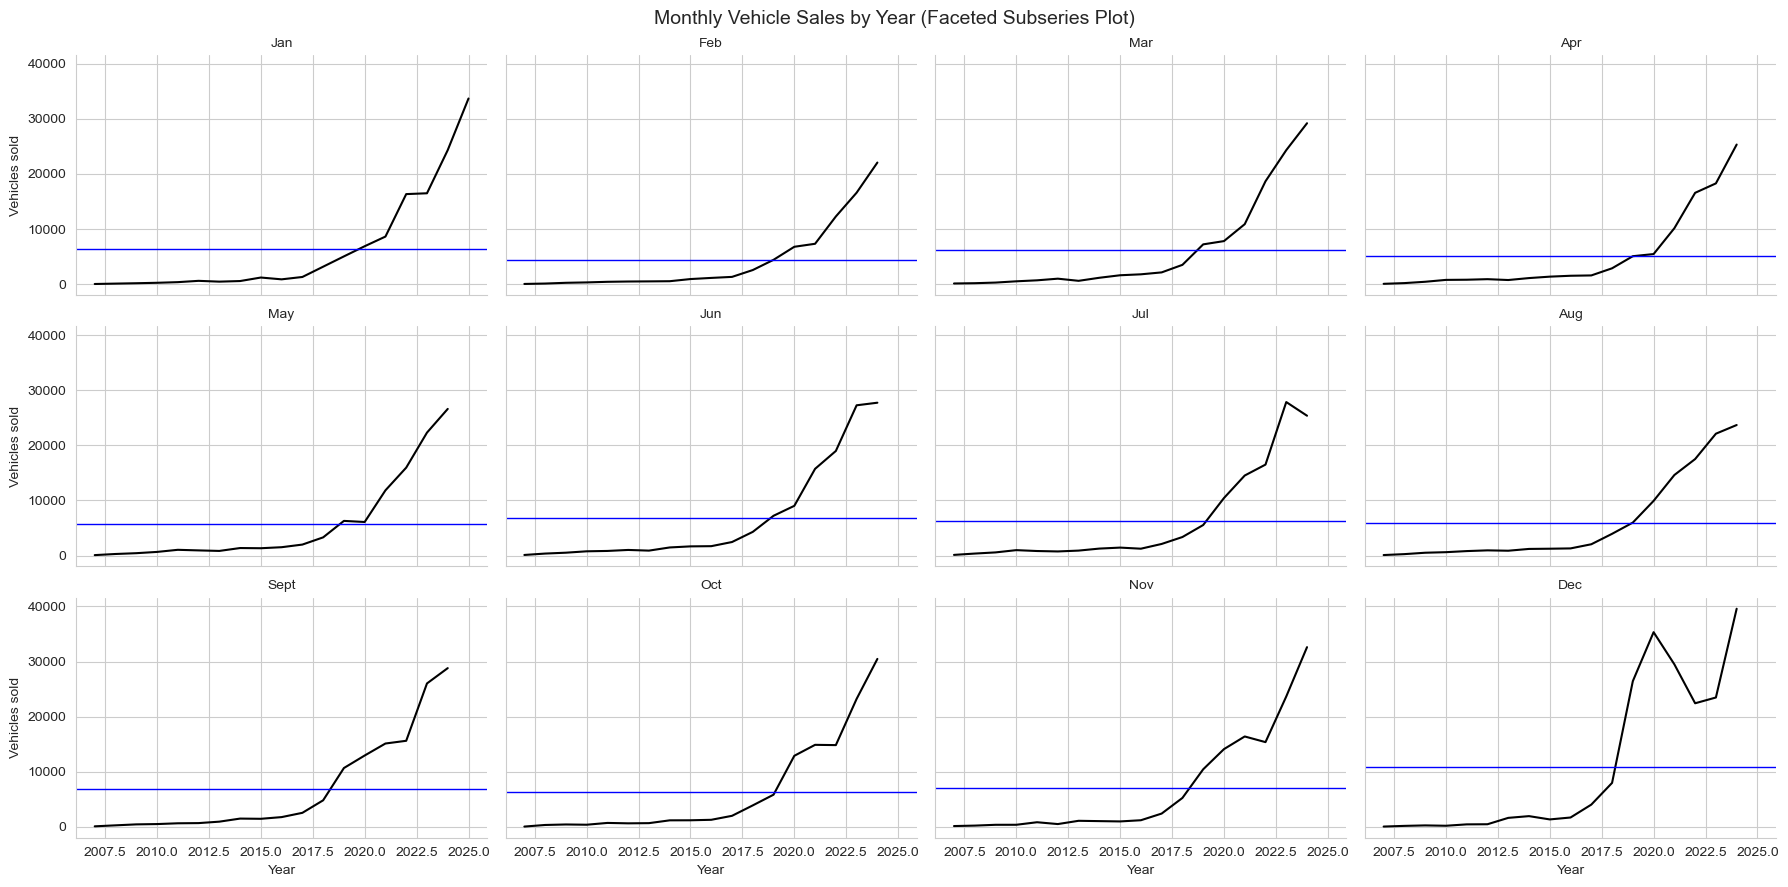

In [9]:
import calendar

# Extract time-based features from the DataFrame
monthly_data = df.copy()
monthly_data['Month'] = monthly_data['Time Period (T)'].dt.month
monthly_data['Year'] = monthly_data['Time Period (T)'].dt.year
monthly_data['MonthName'] = monthly_data['Month'].apply(lambda x: calendar.month_abbr[x])
monthly_data['MonthName'] = pd.Categorical(monthly_data['MonthName'], 
                                           categories=list(calendar.month_abbr)[1:], 
                                           ordered=True)
target_col = 'Log vehicles sold (Target)'
monthly_data['Month'] = monthly_data['Time Period (T)'].dt.month
monthly_data['Year'] = monthly_data['Time Period (T)'].dt.year
monthly_data['MonthName'] = monthly_data['Month'].apply(lambda x: calendar.month_abbr[x])
monthly_data['MonthName'] = pd.Categorical(monthly_data['MonthName'], 
                                           categories=list(calendar.month_abbr)[1:], 
                                           ordered=True)

# Create plot using seaborn's FacetGrid
sns.set_style("whitegrid")
g = sns.FacetGrid(monthly_data, col="MonthName", col_wrap=4, height=3, aspect=1.5, sharey=True)
g.map_dataframe(sns.lineplot, x="Year", y="Total vehicles sold (Target)", color="black")
g.set_axis_labels("Year", "Vehicles sold")
g.set_titles(col_template="{col_name}")

# Add horizontal average line per month
for ax, month in zip(g.axes.flatten(), list(calendar.month_abbr)[1:]):
    subset = monthly_data[monthly_data['MonthName'] == month]
    mean_val = subset['Total vehicles sold (Target)'].mean()
    ax.axhline(mean_val, color='blue', linestyle='-', linewidth=1)

plt.subplots_adjust(top=0.93)
g.fig.suptitle("Monthly Vehicle Sales by Year (Faceted Subseries Plot)", fontsize=14)
plt.show()


the  upward trend is also visable here, after about 2018 all the months have an upwatrd trend. 
but looking at the seasonality, its cleat that december has biggest piek
 

To estimate the underlying trend in my monthly time series data, I apply a moving average to smooth out short-term fluctuations and highlight longer-term patterns. This is especially important in the presence of seasonal effects, which can obscure the true direction of change over time.

Since the data exhibits annual seasonality (12 months), I use a 2×12 moving average. A simple 12-month moving average is not symmetric and can leave residual seasonality in the trend estimate. By applying a second smoothing step (a 2-period moving average) to the 12-MA, the resulting 2×12-MA is a centered, symmetric filter that effectively removes seasonal variation and provides a more accurate estimate of the trend-cycle component.

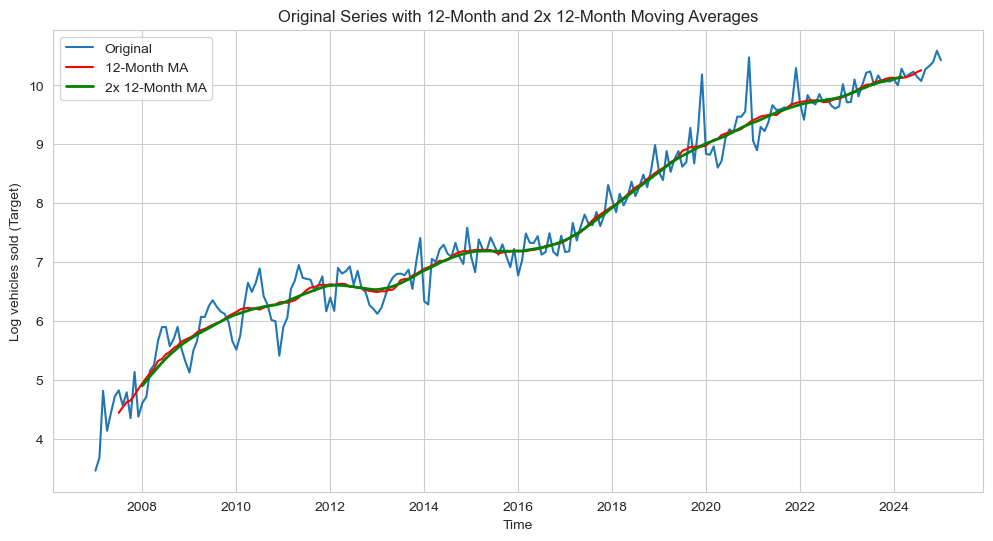

In [43]:
# Calculate 12-month moving average and then a second 12-month moving average on the result
ma_12 = df[target_col].rolling(window=12, center=True).mean()
ma_12_twice = ma_12.rolling(window=12, center=True).mean()

plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], df[target_col], label="Original")
plt.plot(df["Time Period (T)"], ma_12, label="12-Month MA", color="red")
plt.plot(df["Time Period (T)"], ma_12_twice, label="2x 12-Month MA", color="green", linewidth=2)
plt.xlabel("Time")
plt.ylabel(target_col)
plt.title("Original Series with 12-Month and 2x 12-Month Moving Averages")
plt.legend()
plt.show()

### 7 Time series regression models 

Following the methodology of Chapter 7 in FPPPy, I used both time series plots and a scatterplot matrix to explore the relationships between predictors and the target variable. This allowed me to assess linearity, detect multicollinearity, justify the log transformation of the target, and select relevant features for forecasting car sales.

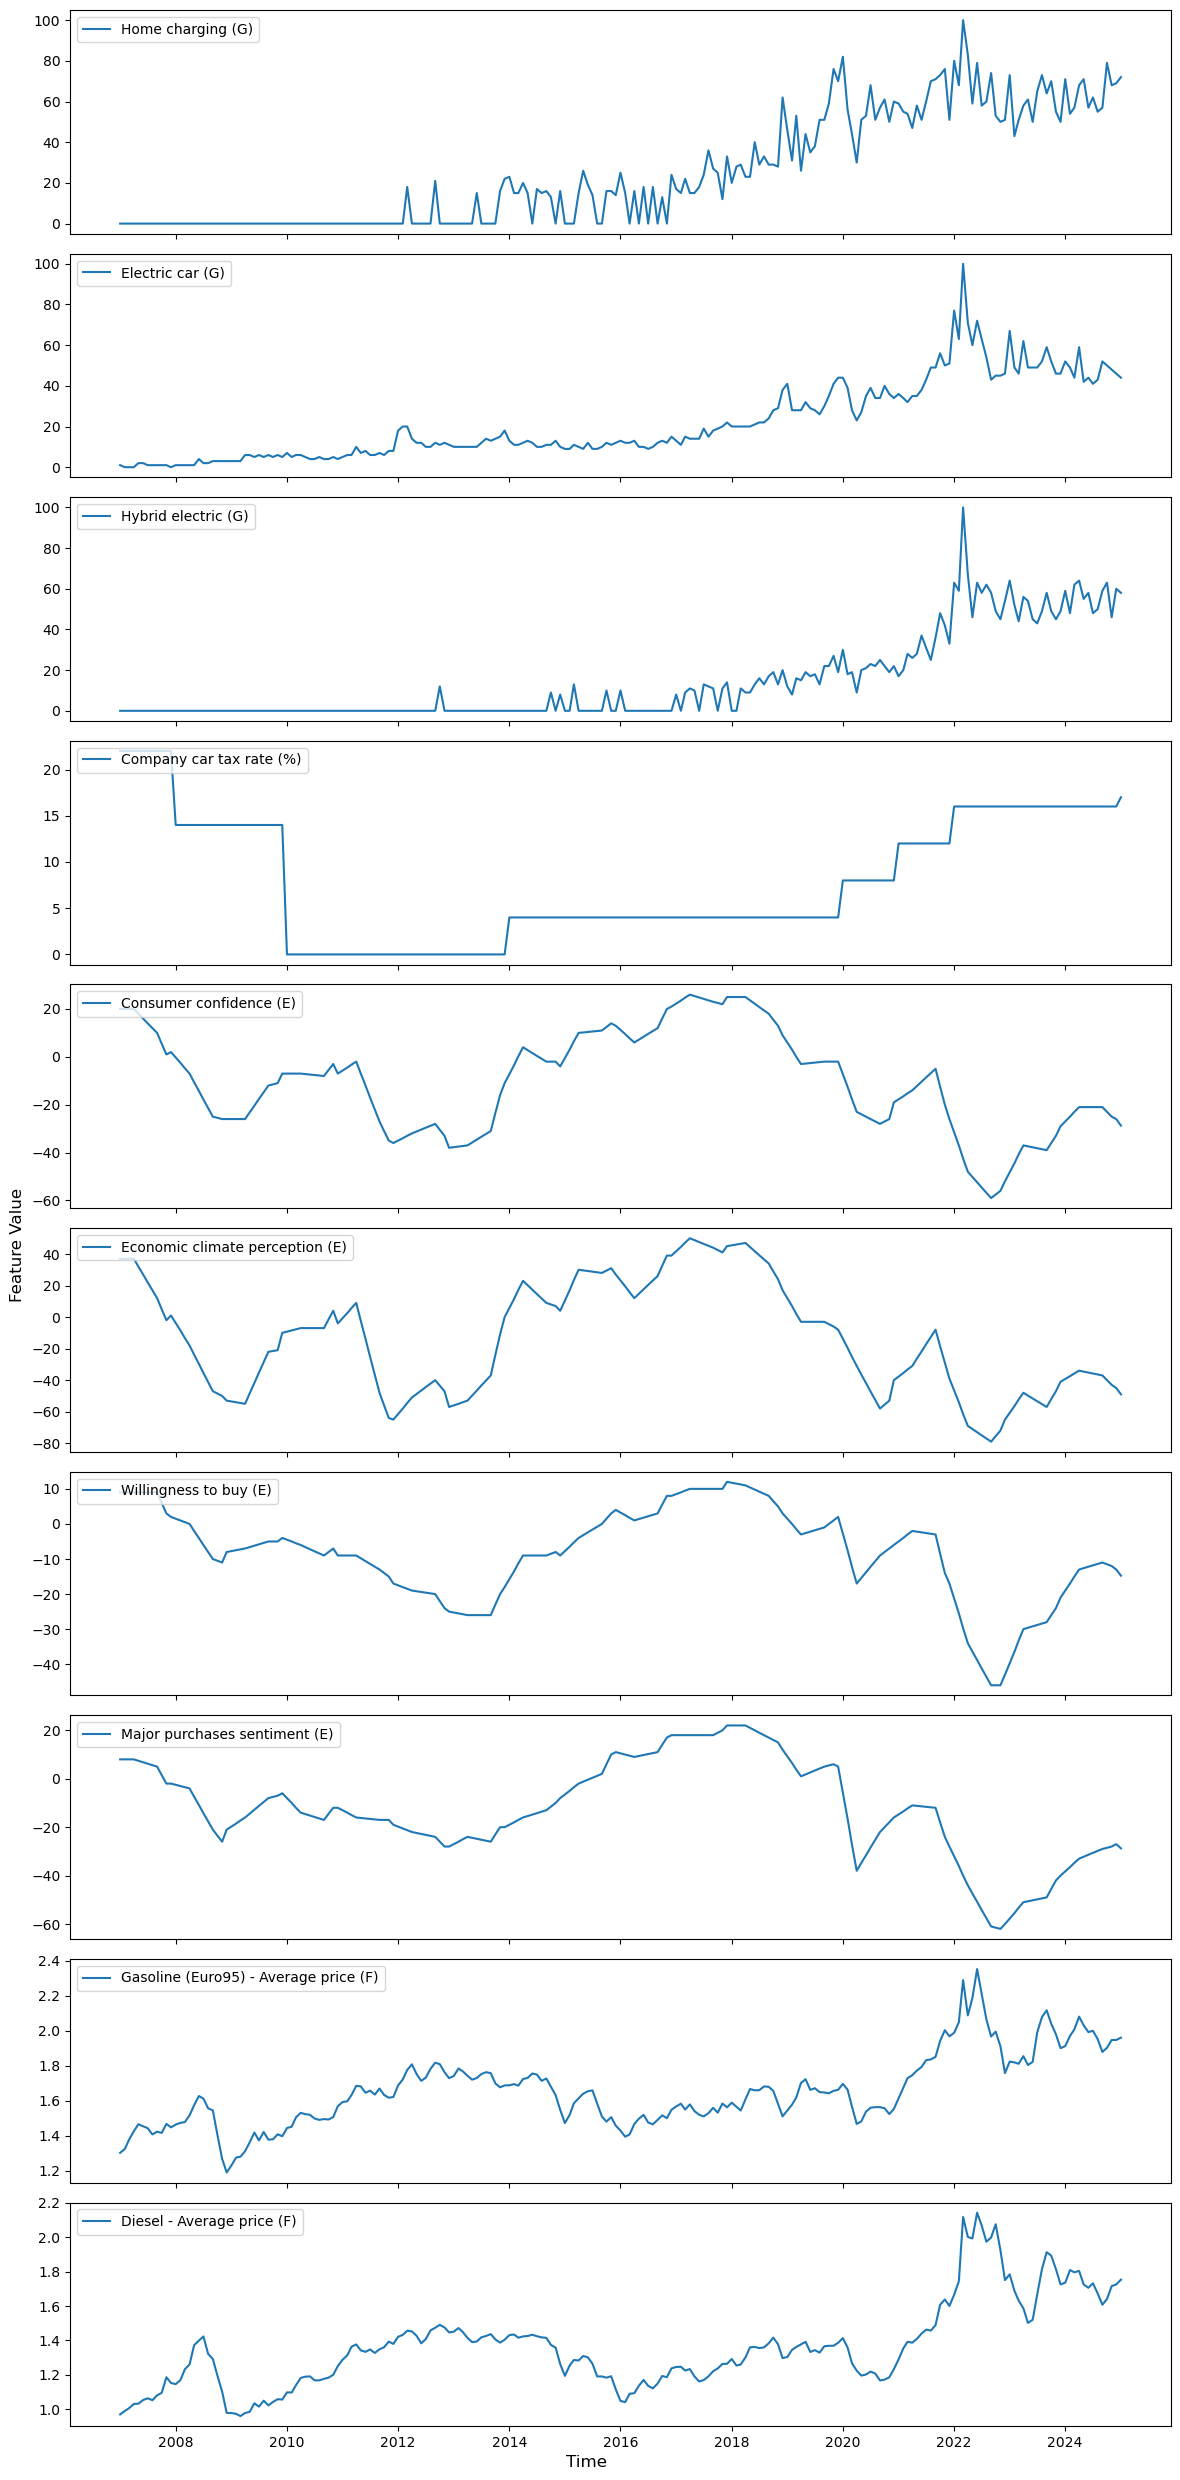

In [33]:
# Select features to plot (excluding the target)
features_to_plot = [ 
    'Home charging (G)', 'Electric car (G)', 'Hybrid electric (G)',
    'Company car tax rate (%)', 'Consumer confidence (E)',
    'Economic climate perception (E)', 'Willingness to buy (E)',
    'Major purchases sentiment (E)', 'Gasoline (Euro95) - Average price (F)',
    'Diesel - Average price (F)'
]

fig, axes = plt.subplots(nrows=len(features_to_plot), ncols=1, figsize=(12, 2.5 * len(features_to_plot)), sharex=True)

for i, feature in enumerate(features_to_plot):
    sns.lineplot(data=df, x="Time Period (T)", y=feature, ax=axes[i], label=feature)
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")
    axes[i].legend(loc='upper left')

fig.supxlabel("Time")
fig.supylabel("Feature Value")
plt.tight_layout()
plt.show()

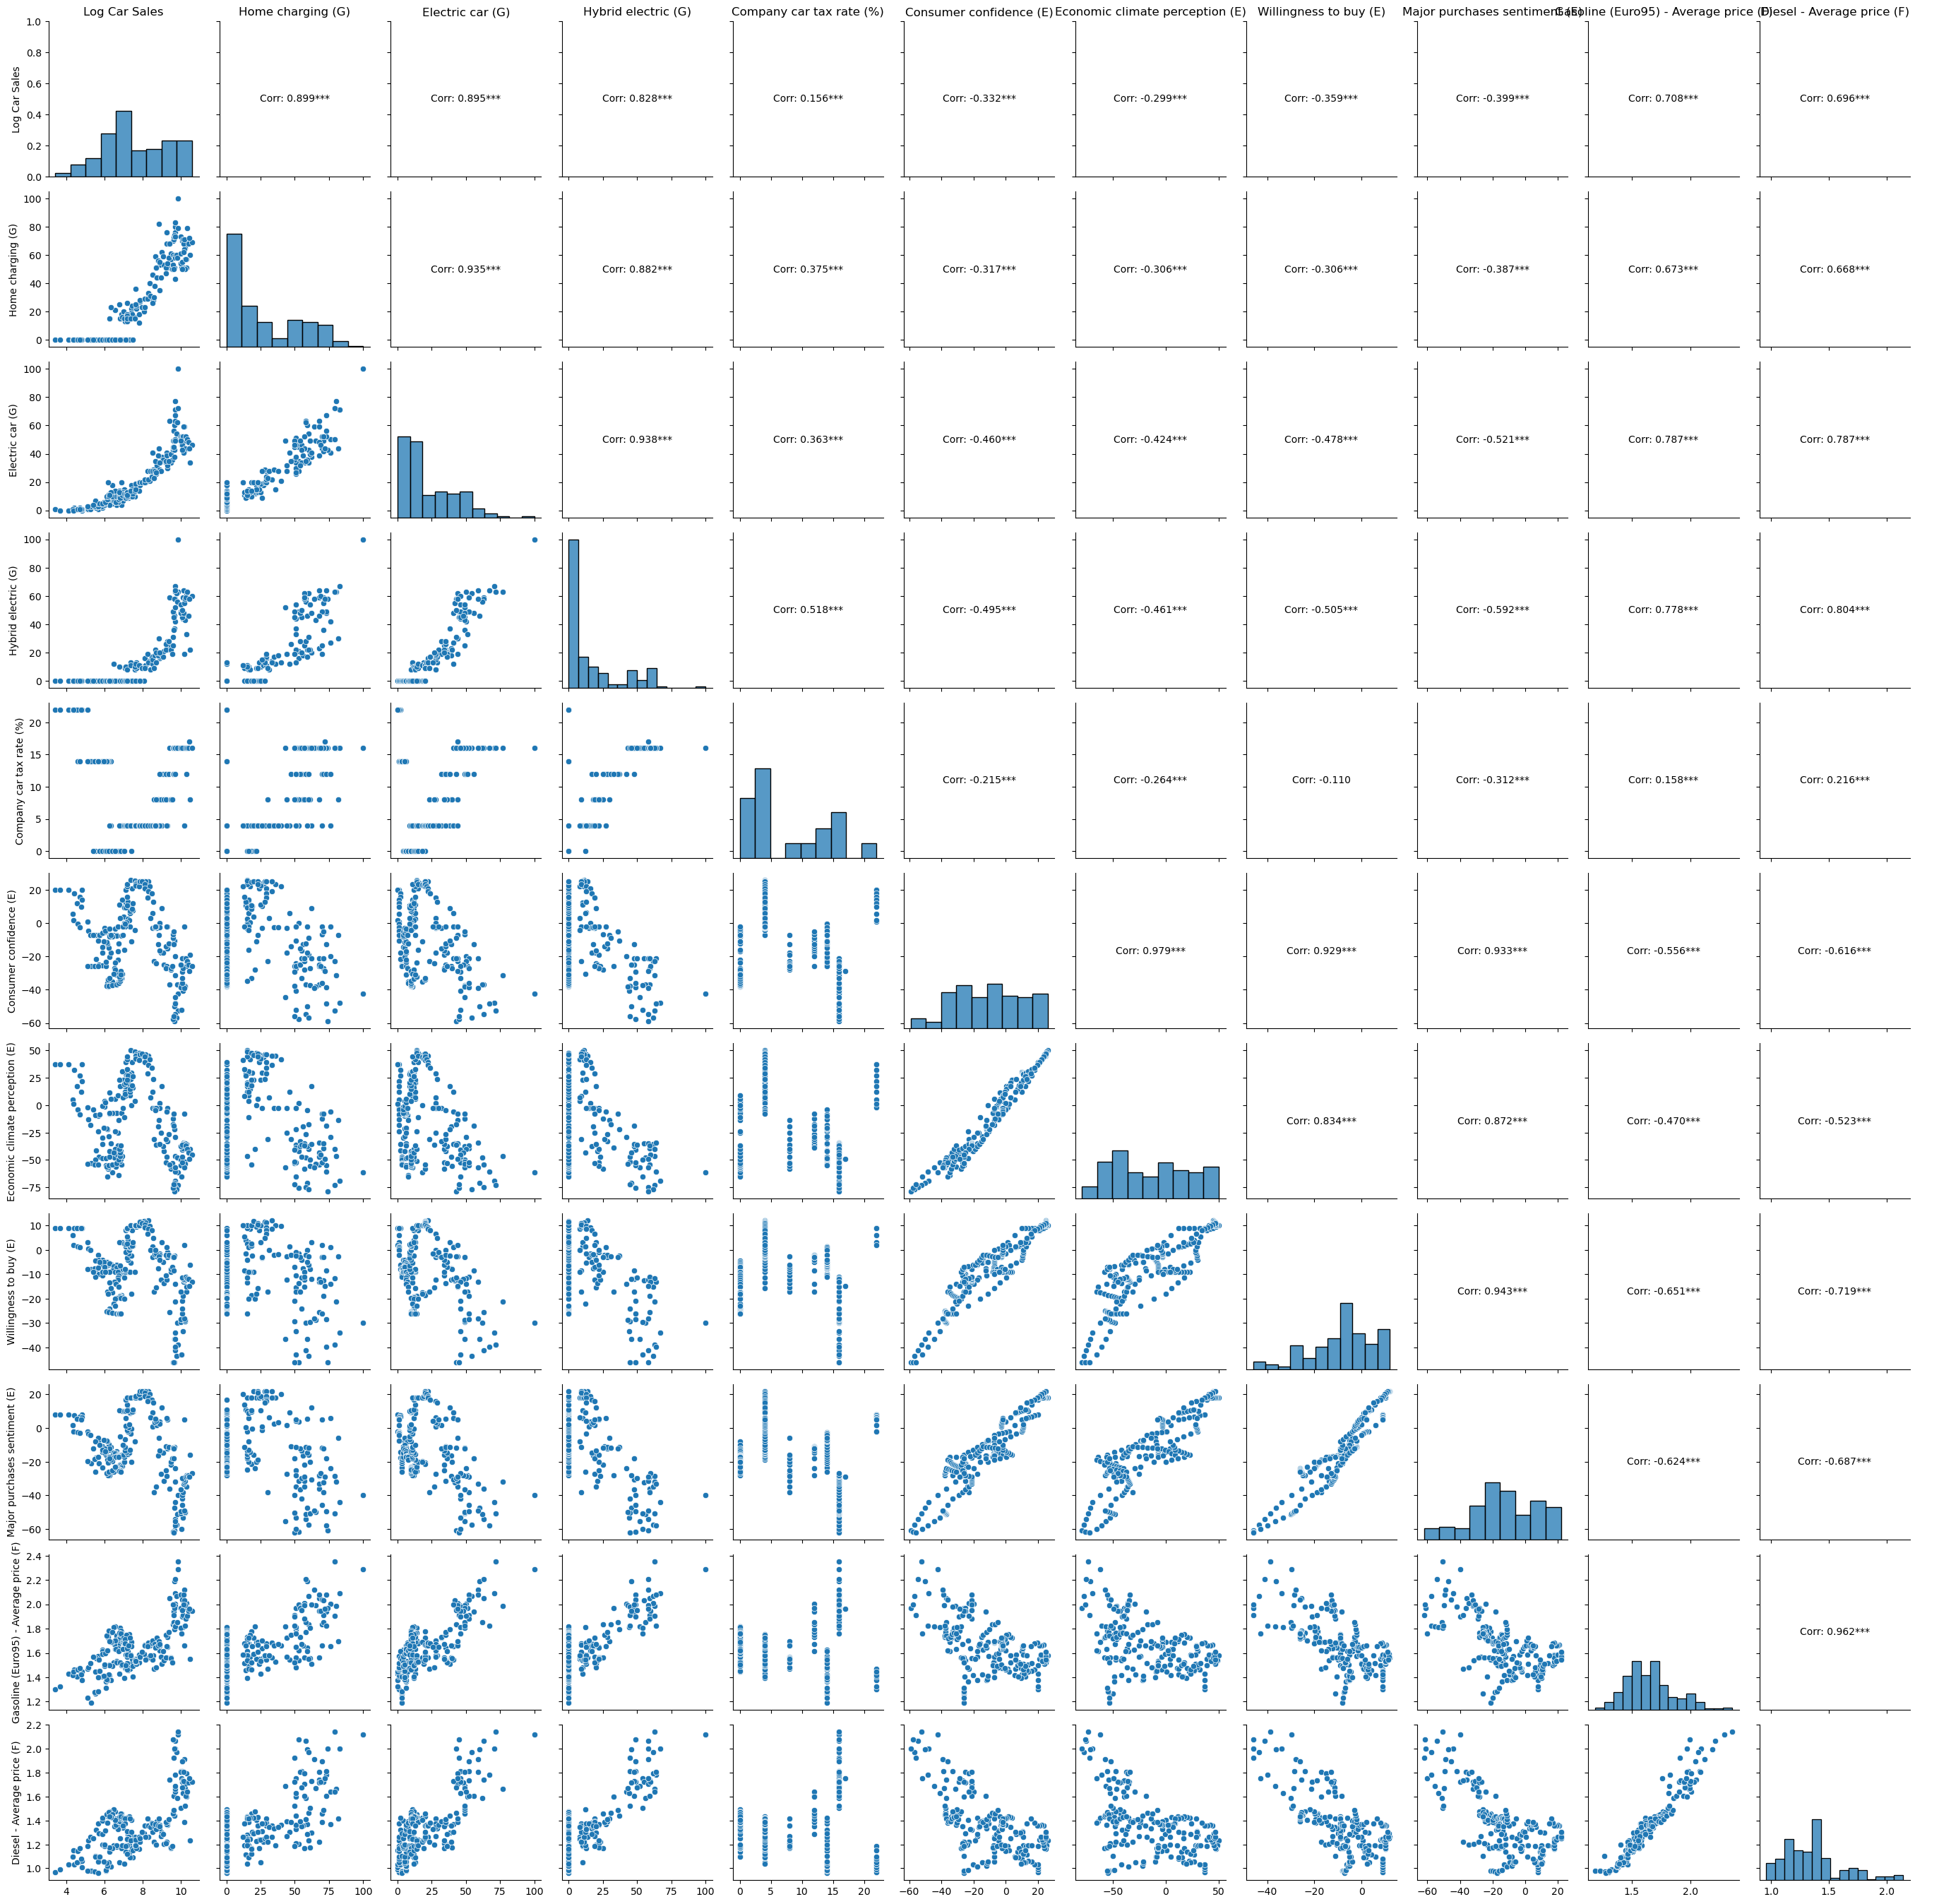

Pearson correlation coefficients (with p-values):
Home charging (G): r = 0.899, p = 0.0000
Electric car (G): r = 0.895, p = 0.0000
Hybrid electric (G): r = 0.828, p = 0.0000
Company car tax rate (%): r = 0.156, p = 0.0218
Consumer confidence (E): r = -0.332, p = 0.0000
Economic climate perception (E): r = -0.299, p = 0.0000
Willingness to buy (E): r = -0.359, p = 0.0000
Major purchases sentiment (E): r = -0.399, p = 0.0000
Gasoline (Euro95) - Average price (F): r = 0.708, p = 0.0000
Diesel - Average price (F): r = 0.696, p = 0.0000


In [18]:
from scipy.stats import pearsonr

# Prepare DataFrame with log car sales and selected features
plot_df = df[["Log vehicles sold (Target)", "Home charging (G)", "Electric car (G)", "Hybrid electric (G)",
              "Company car tax rate (%)", "Consumer confidence (E)", "Economic climate perception (E)",
              "Willingness to buy (E)", "Major purchases sentiment (E)", "Gasoline (Euro95) - Average price (F)",
              "Diesel - Average price (F)"]].copy()
plot_df = plot_df.rename(columns={"Log vehicles sold (Target)": "Log Car Sales"})

def corrfunc(x, y, **kws):
    r, pvalue = pearsonr(x, y)
    ax = plt.gca()
    ax.annotate(
        f"Corr: {r:.3f}{'***' if pvalue < 0.05 else ''}",
        xy=(0.5, 0.5),
        xycoords="axes fraction",
        ha="center",
        va="center",
    )

g = sns.PairGrid(plot_df)
g.map_diag(sns.histplot)
g.map_upper(corrfunc)
g.map_lower(sns.scatterplot)
g.add_legend()
g.set(xlabel="")

for i, col in enumerate(plot_df.columns):
    g.axes[0, i].set_title(col)
plt.show()

# Calculate and print Pearson correlation coefficients and p-values
print("Pearson correlation coefficients (with p-values):")
for col in plot_df.columns[1:]:
    r, p = pearsonr(plot_df["Log Car Sales"], plot_df[col])
    print(f"{col}: r = {r:.3f}, p = {p:.4f}")


A common way to summarise how well a linear regression model fits the data is via the coefficient of determination, R2

To check the stationarity of the time series, I will use the ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots. These plots help identify the presence of autocorrelation in the data, which is crucial for determining the appropriate model for forecasting.

<Figure size 1000x500 with 0 Axes>

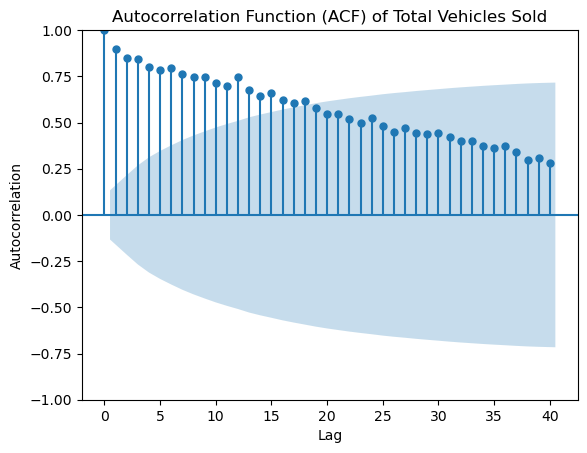

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot ACF for the target variable (Total vehicles sold)
plt.figure(figsize=(10, 5))
plot_acf(df[target_col], lags=40)
plt.title("Autocorrelation Function (ACF) of Total Vehicles Sold")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

Looking at the ACF and PACF plots, we can see that the data is not stationary. The ACF plot shows a slow decay, indicating that there is a long-term correlation in the data. The PACF plot shows a significant spike at lag 1, which suggests that there is a strong correlation between the current value and the previous value.

### Back to arima chapter 9

due to time shortage, went back to chapter 9, following the example in 9.7 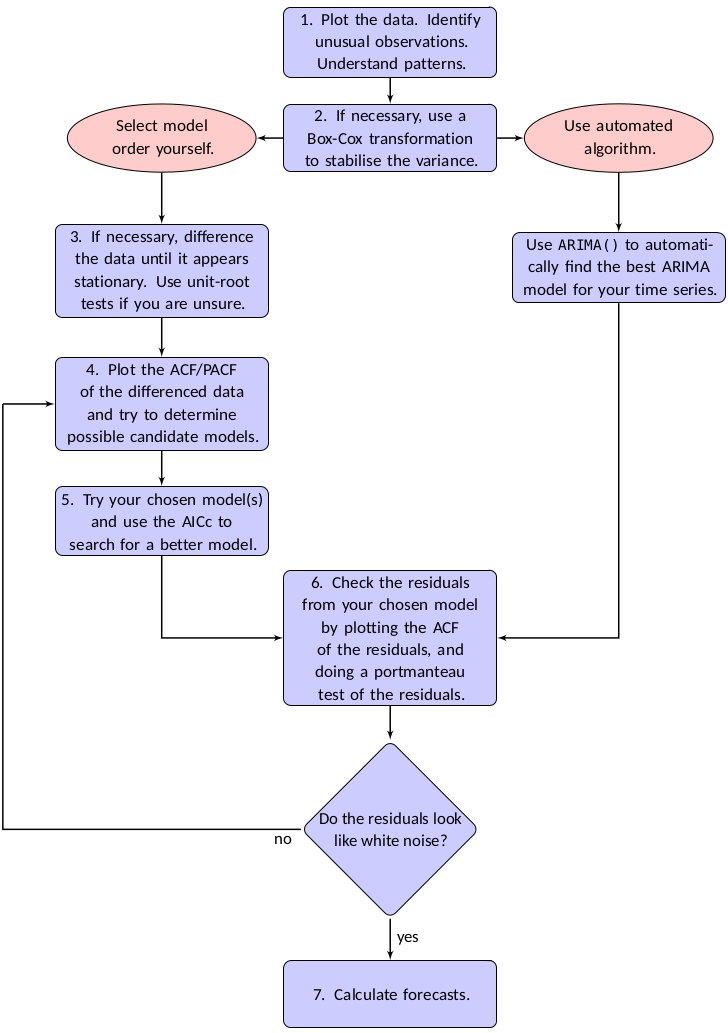

# using Forcasting principles 

## 1 plotting data 

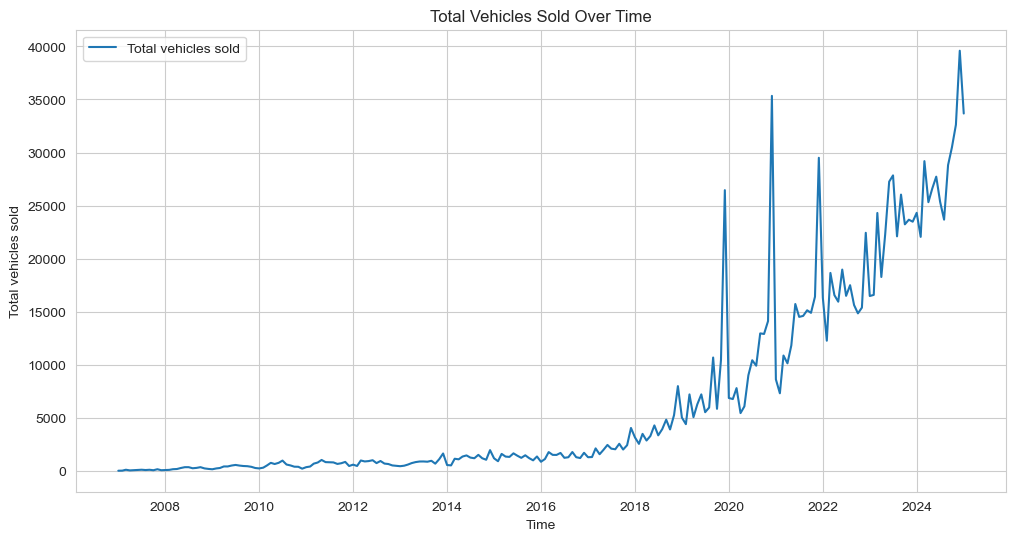

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], df["Total vehicles sold (Target)"], label="Total vehicles sold")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold")
plt.title("Total Vehicles Sold Over Time")
plt.legend()
plt.show()

Time Plot Analysis: Total Vehicle Sales
The time plot of monthly vehicle sales clearly shows high varience and upward trend. Upon closer inspection, several key observations emerge:

There is strong trend growth, particularly from 2020 onward.

The series exhibits seasonality, with recurring peaks and troughs

There are several sharp spikes and increased variance, especially after 2020, possibly due to policy changes or COVID-related disruptions.

To address this non-stationarity, we will begin by applying a first difference to remove the trend. However, given the visible seasonal component (especially the recurring yearly peaks), we may also need to apply a seasonal difference with a 12-month lag.

## 2 performing a Box-Cox transformation because of the variance 

Optimal lambda for Box-Cox: -0.0021


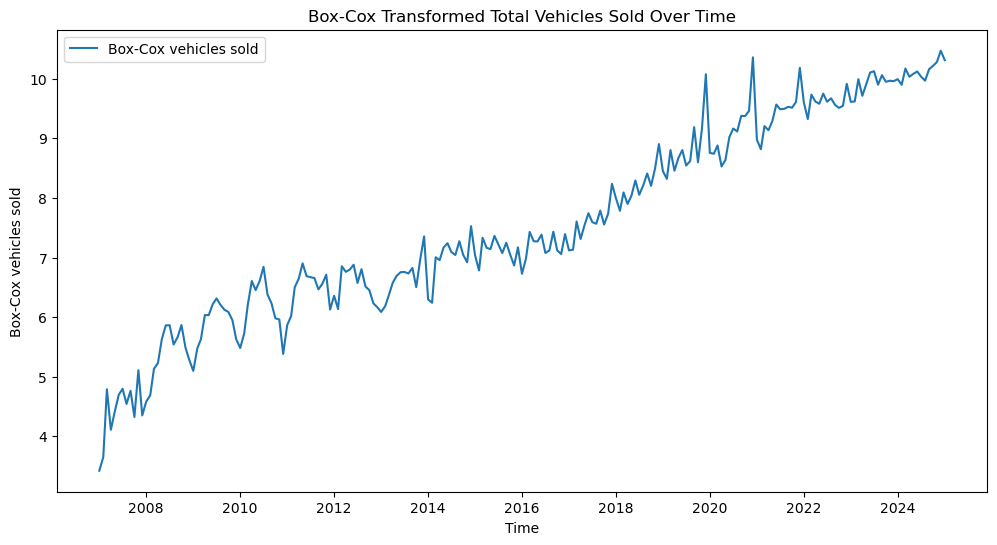

In [5]:
from scipy.stats import boxcox

# Select the target column
target_col = 'Total vehicles sold (Target)'
y = df[target_col].values

# Box-Cox requires all values > 0
if (y <= 0).any():
    raise ValueError("Box-Cox transformation requires all values to be positive.")

# Perform Box-Cox transformation
y_boxcox, fitted_lambda = boxcox(y)

# Add transformed values to the dataframe
df['BoxCox vehicles sold (Target)'] = y_boxcox

print(f"Optimal lambda for Box-Cox: {fitted_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], y_boxcox, label="Box-Cox vehicles sold")
plt.xlabel("Time")
plt.ylabel("Box-Cox vehicles sold")
plt.title("Box-Cox Transformed Total Vehicles Sold Over Time")
plt.legend()
plt.show()

The variencie is much better now, however there is still an upward trend and some seasonality visable in the data, to test the stationality i will performing a unit root test. 

there are several unit root tests available, such as the Augmented Dickey-Fuller (ADF) test, the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test, and the Phillips-Perron (PP) test. I will be using the ADF test, which is a widely used test for stationarity in time series data. 

In [6]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test on the BoxCox-transformed target
result = adfuller(df['BoxCox vehicles sold (Target)'])

print("ADF Statistic: {:.4f}".format(result[0]))
print("p-value: {:.4f}".format(result[1]))
for key, value in result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if result[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

ADF Statistic: -0.8015
p-value: 0.8187
Critical Value (1%): -3.4630
Critical Value (5%): -2.8759
Critical Value (10%): -2.5744
The series is likely non-stationary (fail to reject H0).


> With an ADF statistic of -0.8015, and a high p-value of 0.8187, we have failed to reject the null hypothesis meaning the series still likely contains a unit root (i.e. it's non-stationary) even after applying Box-Cox.

my next step is to apply a first difference to the data to remove the trend, and then re-evaluate stationarity using the ADF test again.

> Time plot and ACF and PACF plots for the differenced

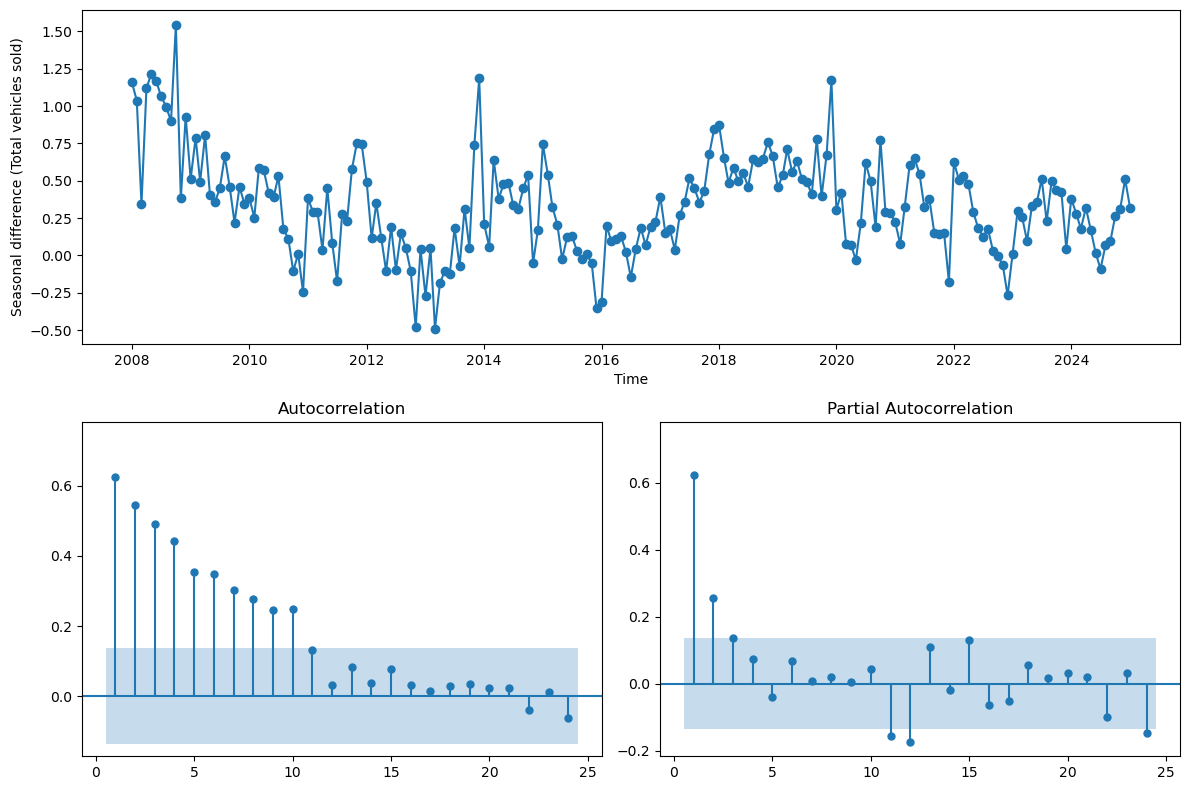

ADF Statistic (seasonal differenced): -3.5399
p-value: 0.0070
Critical Value (1%): -3.4649
Critical Value (5%): -2.8767
Critical Value (10%): -2.5749
The series is likely stationary (reject H0).


In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Calculate 12-lag (seasonal) difference of the target variable
seasonal_diff = df["BoxCox vehicles sold (Target)"].diff(12).dropna()

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(df["Time Period (T)"].iloc[12:], seasonal_diff, marker="o")
ax1.set_ylabel("Seasonal difference (Total vehicles sold)")
ax1.set_xlabel("Time")

plot_acf(seasonal_diff, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(seasonal_diff, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# Perform Augmented Dickey-Fuller test on the seasonal differenced data
adf_result = adfuller(seasonal_diff)

print("ADF Statistic (seasonal differenced): {:.4f}".format(adf_result[0]))
print("p-value: {:.4f}".format(adf_result[1]))
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")


looking at the seasonal differenced data it looks like white noice, taking a nother chance at the adf test we can see the P-value of 0.007, meaning wve  rejected the null hypothesis  and the series is now stationary

## determining the model

looking at the ACF plot we can sseee a significant spike at lag 1, and mold decay afterwards, this hints at non-seasonal MA(1) 

Looking at the PACF plot:
We see  promintent spike at lag 1 and pobbiple lag 2 but drops off quicly, 

this suggest non seasonal AR1 anbd possibly AR2.


Seasonal interpretations lag 12-24

ACF PLOT shows clear spike at lag 12 
pacf plot shows souke at lag 12 then mils decay 

seasonal AR(1) 

SARIMA(1,1,1)(1,1,1)[12]


## Fitting  the model 

In [14]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model
model = SARIMAX(
    df["BoxCox vehicles sold (Target)"],
    order=(1, 0, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())



                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  217
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                  15.563
Date:                            Thu, 10 Jul 2025   AIC                            -21.126
Time:                                    10:26:07   BIC                             -4.865
Sample:                                         0   HQIC                           -14.539
                                            - 217                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9721      0.017     55.951      0.000       0.938       1.006
ma.L1         -0.5083      0.050   

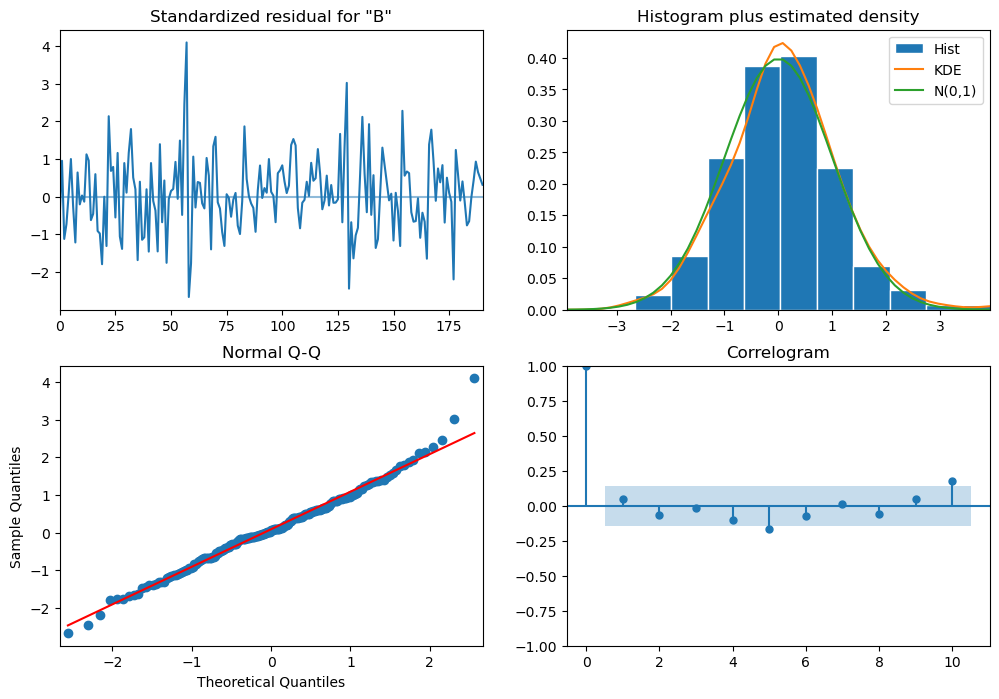

In [15]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()


> These are also clearly non-stationary, so we take a further first difference 

### next steps 

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMA model
model = SARIMAX(
    df["BoxCox vehicles sold (Target)"],
    order=(1, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())




                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  217
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  15.765
Date:                            Thu, 10 Jul 2025   AIC                            -23.530
Time:                                    10:32:06   BIC                            -10.521
Sample:                                         0   HQIC                           -18.260
                                            - 217                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9684      0.017     57.542      0.000       0.935       1.001
ma.L1         -0.5086      0.048   

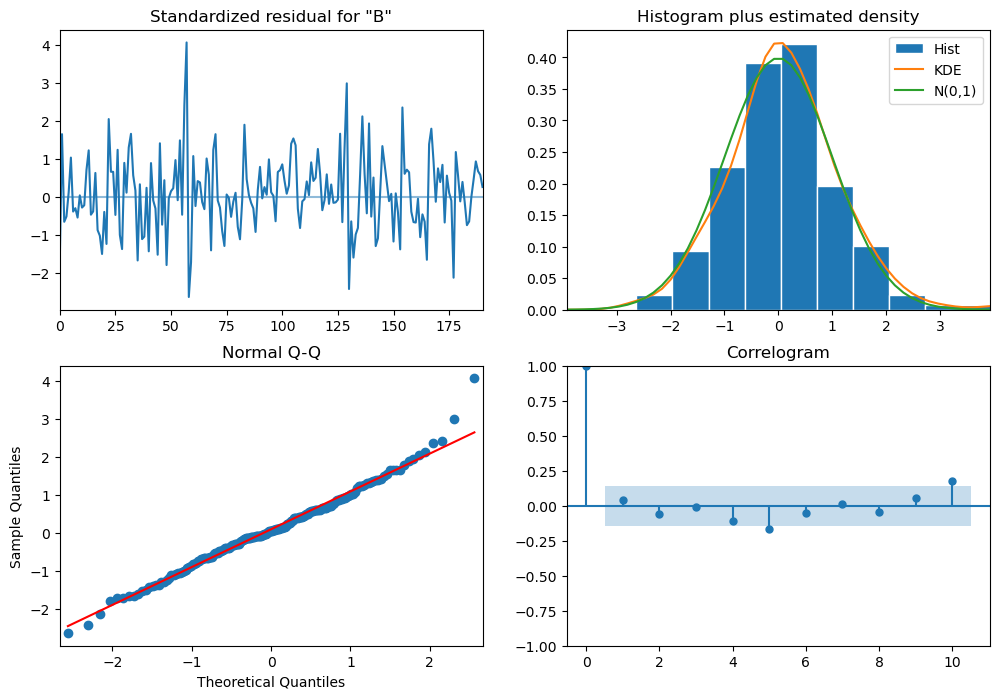

In [19]:
results.plot_diagnostics(figsize=(12, 8))
plt.show()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-8.913, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=139.420, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=4.456, Time=0.15 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=30.718, Time=0.24 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=139.416, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=29.059, Time=0.70 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-9.191, Time=0.81 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=77.243, Time=0.21 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=-8.863, Time=3.76 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=-8.457, Time=3.31 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=-11.700, Time=0.64 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=98.239, Time=0.19 sec
 ARIMA(1,1,2)(2,0,0)[12] intercept   : AIC=-11.191, Time=2.85 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=-10.714, Time=0.79 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=

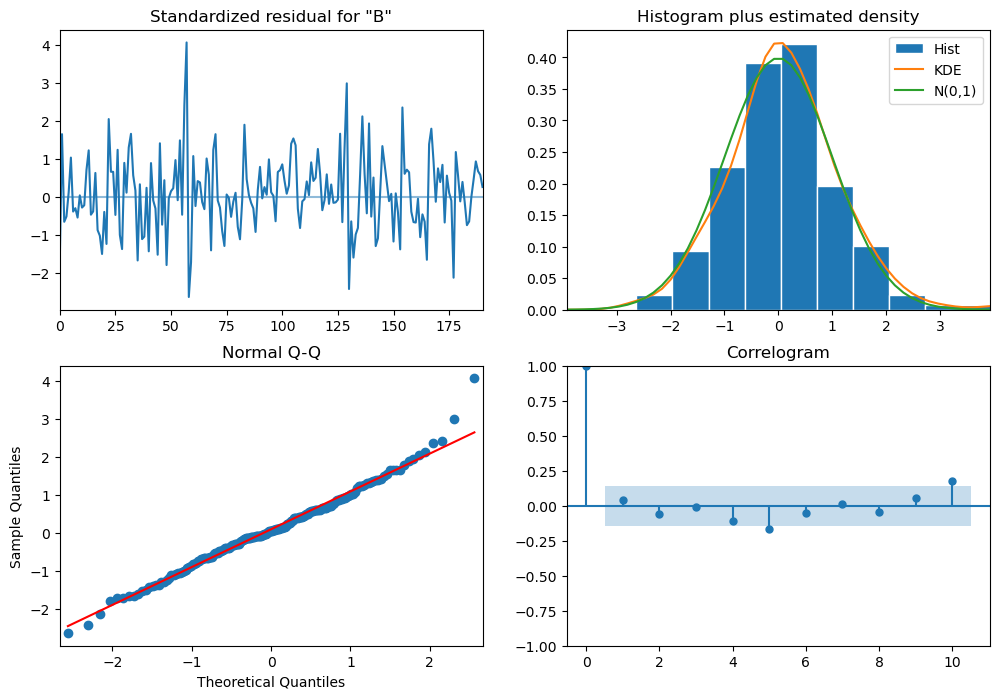

In [20]:
from pmdarima import auto_arima

# Fit auto_arima on BoxCox-transformed target
auto_model_boxcox = auto_arima(
    df["BoxCox vehicles sold (Target)"],
    seasonal=True,
    m=12,  # monthly seasonality
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(auto_model_boxcox.summary())

results.plot_diagnostics(figsize=(12, 8))
plt.show()

> Auto arima perfomed worse, then manual tuned one s model has:

AIC: –12.12, which is worse than your manually fit model SARIMA(1,0,1)(0,1,1)[12] with AIC: –23.53

Higher BIC and HQIC too ✅ Suggests your manual model may be better despite the auto_arima guess


## Forcasting

                                     SARIMAX Results                                      
Dep. Variable:      BoxCox vehicles sold (Target)   No. Observations:                  217
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  15.765
Date:                            Thu, 10 Jul 2025   AIC                            -23.530
Time:                                    10:40:45   BIC                            -10.521
Sample:                                         0   HQIC                           -18.260
                                            - 217                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9684      0.017     57.542      0.000       0.935       1.001
ma.L1         -0.5086      0.048   

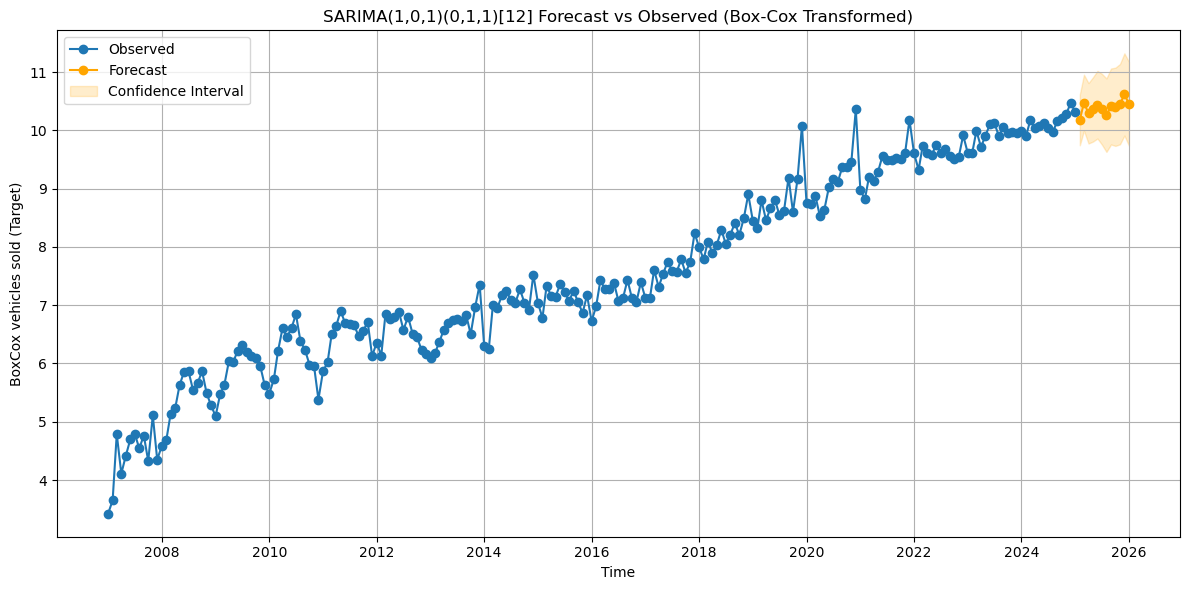

Back-transformed MAPE: 0.2892
Back-transformed RMSE: 8187.74


In [23]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Fit SARIMA(1,0,1)(0,1,1)[12] model on BoxCox-transformed target
sarima_model = SARIMAX(
    df["BoxCox vehicles sold (Target)"],
    order=(1, 0, 1),
    seasonal_order=(0, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarima_results = sarima_model.fit()
print(sarima_results.summary())

# Forecast 12 steps ahead
forecast_steps = 12
sarima_pred = sarima_results.get_forecast(steps=forecast_steps)
sarima_forecast = sarima_pred.predicted_mean
sarima_conf_int = sarima_pred.conf_int()

# Create time index for forecasts
last_date = df["Time Period (T)"].iloc[-1]
sarima_forecast_index = pd.date_range(last_date, periods=forecast_steps + 1, freq='MS')[1:]

# Plot observed vs forecasted
plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], df["BoxCox vehicles sold (Target)"], label="Observed", marker='o')
plt.plot(sarima_forecast_index, sarima_forecast, label="Forecast", color="orange", marker='o')
plt.fill_between(
    sarima_forecast_index,
    sarima_conf_int.iloc[:, 0],
    sarima_conf_int.iloc[:, 1],
    color="orange",
    alpha=0.2,
    label="Confidence Interval"
)
plt.title("SARIMA(1,0,1)(0,1,1)[12] Forecast vs Observed (Box-Cox Transformed)")
plt.xlabel("Time")
plt.ylabel("BoxCox vehicles sold (Target)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Inverse Box-Cox transformation
def inv_boxcox(y, lam):
    if abs(lam) < 1e-6:
        return np.exp(y)
    else:
        return np.power(lam * y + 1, 1 / lam)

# Get actuals for the forecast period
actuals = df["Total vehicles sold (Target)"].iloc[-forecast_steps:].values
# Back-transform forecasts
forecast_back = inv_boxcox(sarima_forecast.values, fitted_lambda)

# Calculate metrics
mape = mean_absolute_percentage_error(actuals, forecast_back)
rmse = np.sqrt(mean_squared_error(actuals, forecast_back))

print(f"Back-transformed MAPE: {mape:.4f}")
print(f"Back-transformed RMSE: {rmse:.2f}")


XGBoost MAPE: 0.1833
XGBoost RMSE: 7393.38


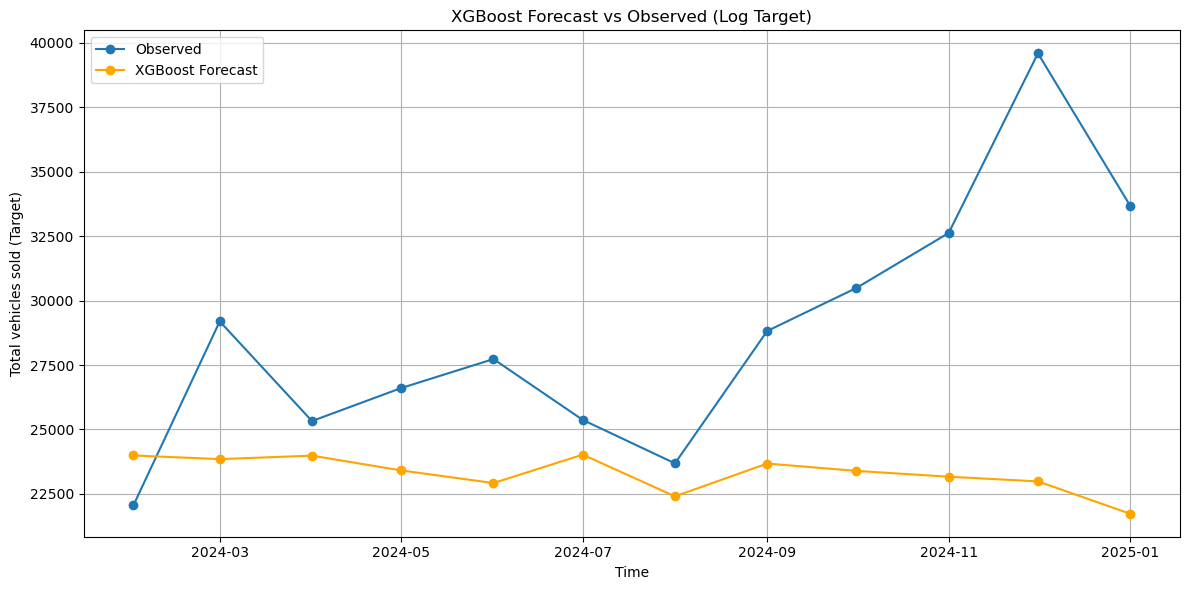

In [25]:
# Use only the log-transformed target for supervised learning
y_log = np.log(df['Total vehicles sold (Target)'].values[lookback:])

# Train/test split: last 12 for test (forecast), rest for train
y_train_log, y_test_log = y_log[:-forecast_steps], y_log[-forecast_steps:]

# Fit XGBoost regressor on log target
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train_log)

# Forecast (predict) next 12 months (log scale)
xgb_forecast_log = xgb_model.predict(X_test)
xgb_forecast = np.exp(xgb_forecast_log)  # back-transform to original scale

# Metrics
mape_xgb = mean_absolute_percentage_error(y_test, xgb_forecast)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_forecast))

print(f"XGBoost MAPE: {mape_xgb:.4f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")

# Plot observed vs forecasted
plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"].iloc[-forecast_steps:], y_test, label="Observed", marker='o')
plt.plot(df["Time Period (T)"].iloc[-forecast_steps:], xgb_forecast, label="XGBoost Forecast", marker='o', color='orange')
plt.title("XGBoost Forecast vs Observed (Log Target)")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold (Target)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


xgboost still outperforms the SARIMA model, but the SARIMA model is more interpretable and easier to explain to stakeholders 

XGBoost MAPE: 0.1922
XGBoost RMSE: 8199.77


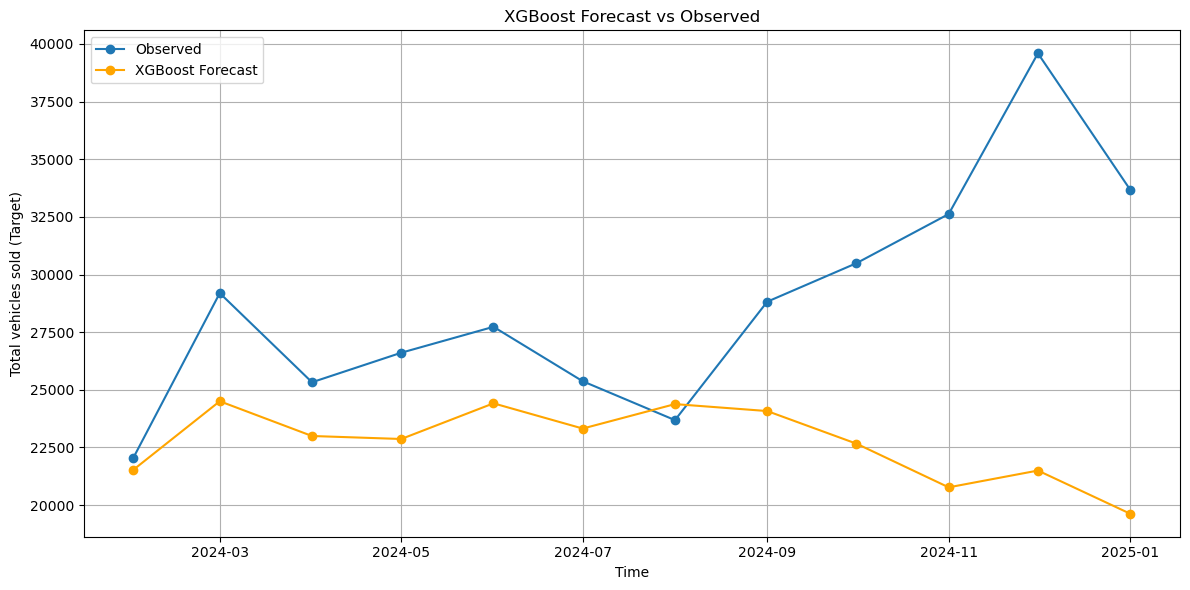

In [29]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Prepare features for supervised learning
# Use all columns except the target and time
feature_cols = [
    'Home charging (G)', 'Electric car (G)', 'Hybrid electric (G)',
    'Company car tax rate (%)', 'Consumer confidence (E)',
    'Economic climate perception (E)', 'Willingness to buy (E)',
    'Major purchases sentiment (E)', 'Gasoline (Euro95) - Average price (F)',
    'Diesel - Average price (F)'
]

# Use previous 12 months to predict the next month (rolling window)
lookback = 12
X, y_xgb = [], []
for i in range(lookback, len(df)):
    # Flatten previous 12 months of features
    X.append(df[feature_cols].iloc[i-lookback:i].values.flatten())
    y_xgb.append(df['Total vehicles sold (Target)'].iloc[i])

X = np.array(X)
y_xgb = np.array(y_xgb)

# Train/test split: last 12 for test (forecast), rest for train
X_train, X_test = X[:-forecast_steps], X[-forecast_steps:]
y_train, y_test = y_xgb[:-forecast_steps], y_xgb[-forecast_steps:]

# Fit XGBoost regressor
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Forecast (predict) next 12 months
xgb_forecast = xgb_model.predict(X_test)

# Metrics
mape_xgb = mean_absolute_percentage_error(y_test, xgb_forecast)
rmse_xgb = np.sqrt(mean_squared_error(y_test, xgb_forecast))

print(f"XGBoost MAPE: {mape_xgb:.4f}")
print(f"XGBoost RMSE: {rmse_xgb:.2f}")

# Plot observed vs forecasted
plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"].iloc[-forecast_steps:], y_test, label="Observed", marker='o')
plt.plot(df["Time Period (T)"].iloc[-forecast_steps:], xgb_forecast, label="XGBoost Forecast", marker='o', color='orange')
plt.title("XGBoost Forecast vs Observed")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold (Target)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Adding features to the model

the fitst step is to verifiy that my target value able is statopnary, since ive done that i can go on to check teh candidate feature for stationarity 

since in my last approach my model performed better without extra features i will take an incremental apporach this time around. ive performed pca test first time aouround 


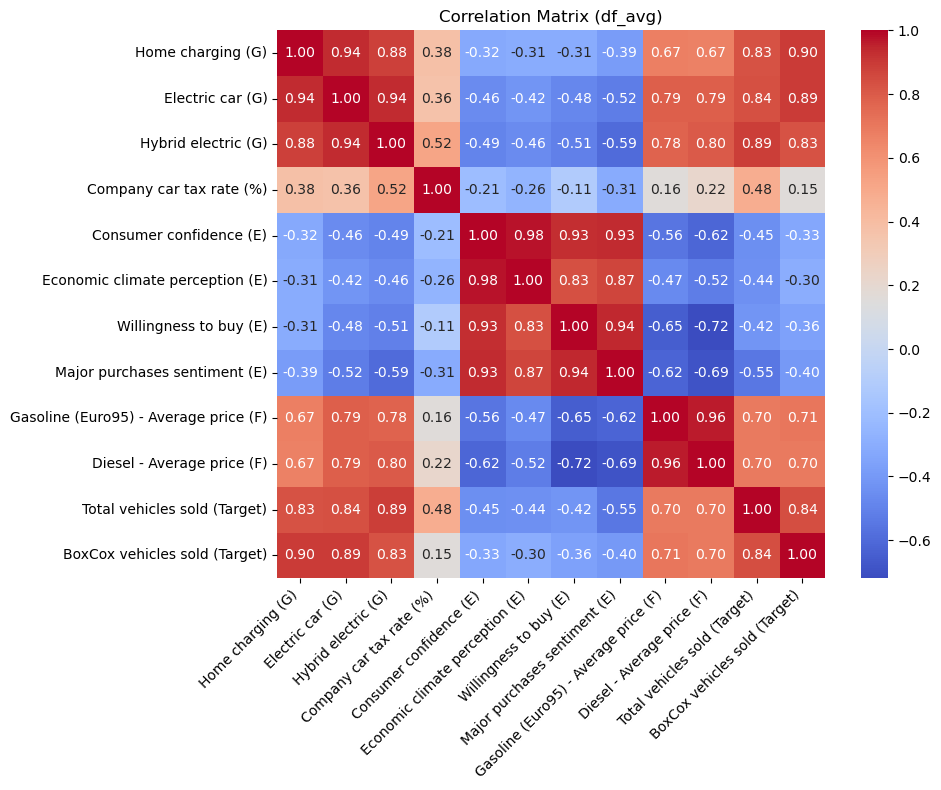

In [31]:
# Compute correlation matrix for df_avg
corr_matrix_avg = df.select_dtypes(include=['number']).corr()

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix_avg, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (df_avg)")
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

looking at the heatmap we see alot of mulicollinearity, this will make it harder on the model when adding extroogenous variables. in order to reduce the multicollinearity, I used PCA first, but will use VIF now to  Use VIF to diagnose and clean multicollinearity 

In [34]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Prepare feature matrix for VIF (exclude target and date columns)
X_vif = df[feature_cols].copy()

# Calculate VIF for each feature
vif_data = pd.DataFrame({
    'feature': X_vif.columns,
    'VIF': [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]
})

print(vif_data)

                                 feature          VIF
0                      Home charging (G)    20.563727
1                       Electric car (G)    49.268335
2                    Hybrid electric (G)    22.835246
3               Company car tax rate (%)     5.138584
4                Consumer confidence (E)  8187.414043
5        Economic climate perception (E)  3379.623611
6                 Willingness to buy (E)  1337.281661
7          Major purchases sentiment (E)    29.810758
8  Gasoline (Euro95) - Average price (F)   631.559223
9             Diesel - Average price (F)   690.715827


### Company car tax rate (%) 

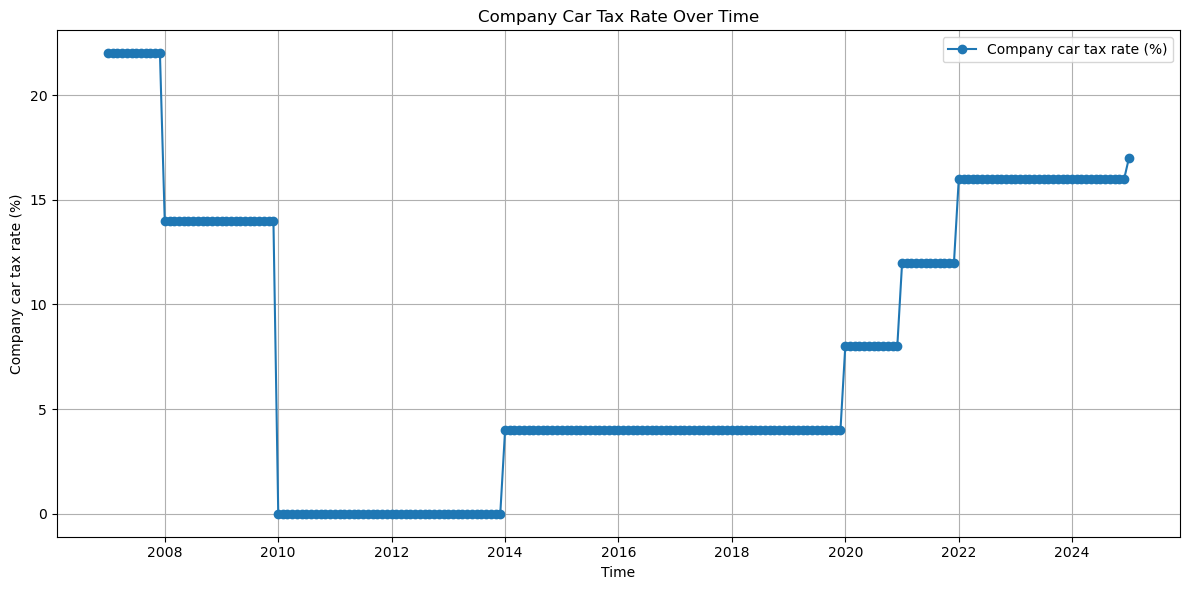

In [35]:
plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], df["Company car tax rate (%)"], marker='o', label="Company car tax rate (%)")
plt.xlabel("Time")
plt.ylabel("Company car tax rate (%)")
plt.title("Company Car Tax Rate Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

super hig varience, will perform box cox 

Box-Cox lambda (after +1 shift): 0.3553


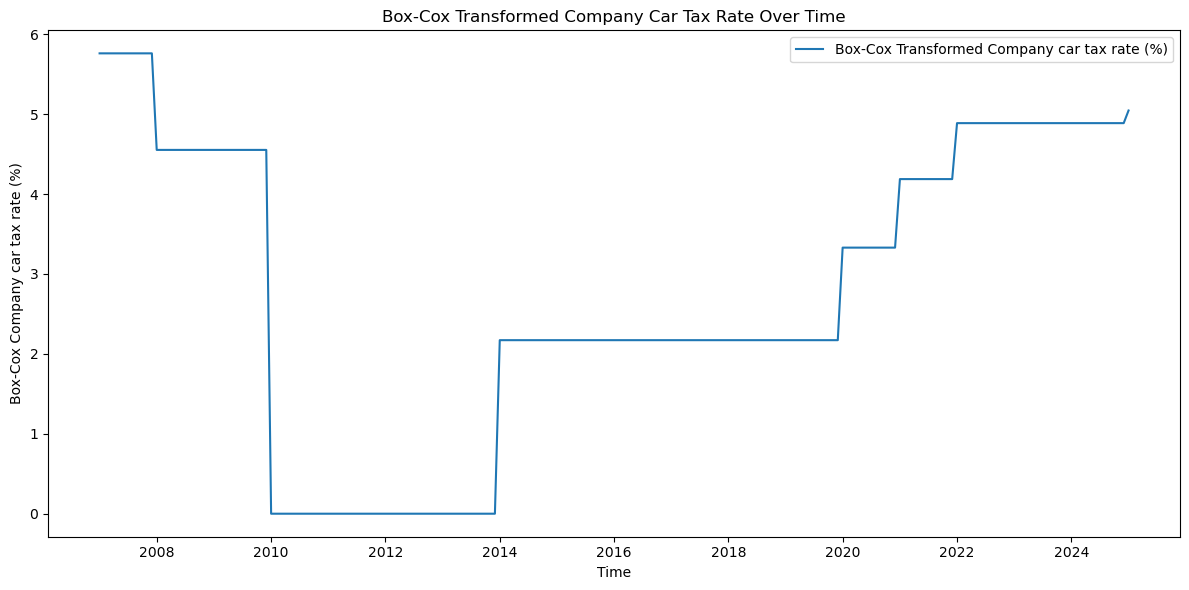

In [ ]:
# Add a small shift to make all values strictly positive
tax_values_shifted = tax_values + 1

# Apply Box-Cox
tax_boxcox, tax_lambda = boxcox(tax_values_shifted)

# Save transformed values
df['BoxCox ' + tax_col] = tax_boxcox

print(f"Box-Cox lambda (after +1 shift): {tax_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], tax_boxcox, label="Box-Cox Transformed Company car tax rate (%)")
plt.xlabel("Time")
plt.ylabel("Box-Cox Company car tax rate (%)")
plt.title("Box-Cox Transformed Company Car Tax Rate Over Time")
plt.legend()
plt.tight_layout()
plt.show()


> lets check  for stationarity after the box cox transformation

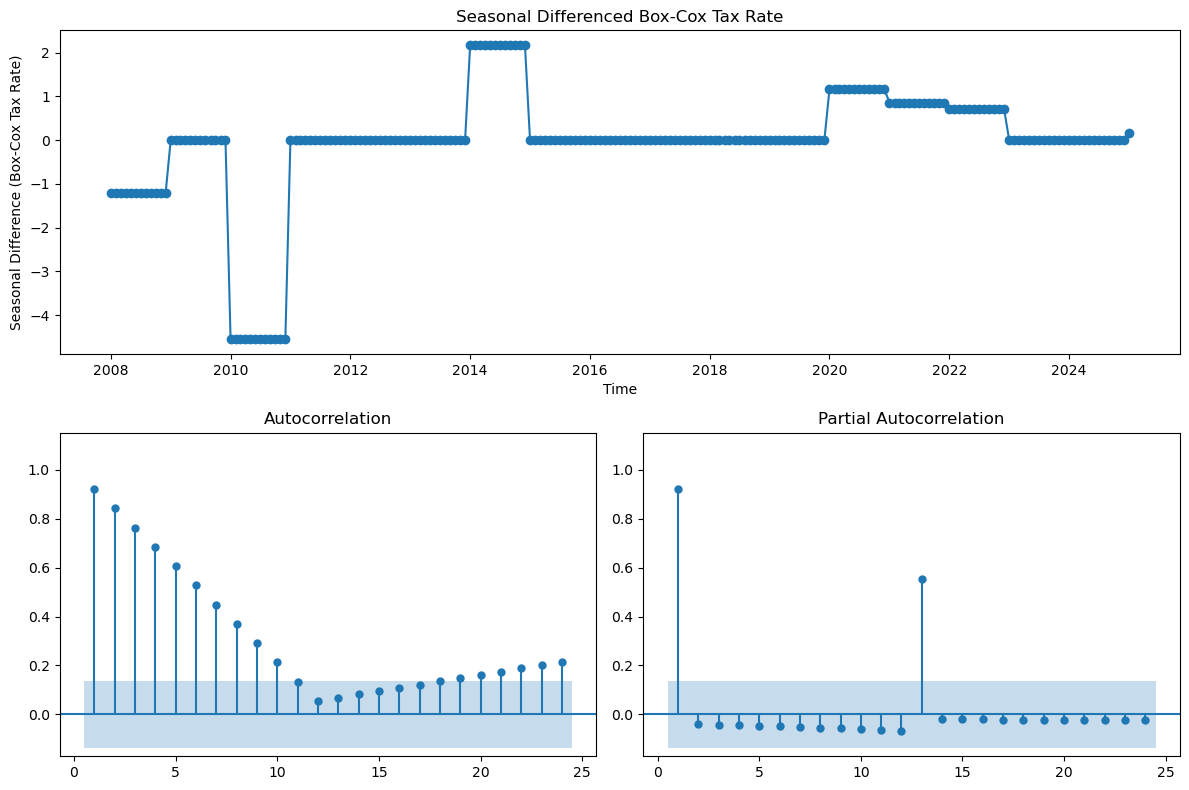

ADF Statistic (seasonal differenced): -1.9011
p-value: 0.3315
Critical Value (1%): -3.4649
Critical Value (5%): -2.8767
Critical Value (10%): -2.5749
The series is likely non-stationary (fail to reject H0).


In [40]:

# Convert tax_boxcox to Series to align with time index
tax_boxcox_series = pd.Series(tax_boxcox, index=df.index)

# Compute 12-lag seasonal difference
seasonal_diff = tax_boxcox_series.diff(12).dropna()

# Create plots
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Time-series plot
ax1.plot(df["Time Period (T)"].iloc[12:], seasonal_diff, marker="o")
ax1.set_ylabel("Seasonal Difference (Box-Cox Tax Rate)")
ax1.set_xlabel("Time")
ax1.set_title("Seasonal Differenced Box-Cox Tax Rate")

# ACF and PACF
plot_acf(seasonal_diff, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(seasonal_diff, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# ADF Test
adf_result = adfuller(seasonal_diff)

print("ADF Statistic (seasonal differenced): {:.4f}".format(adf_result[0]))
print("p-value: {:.4f}".format(adf_result[1]))
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

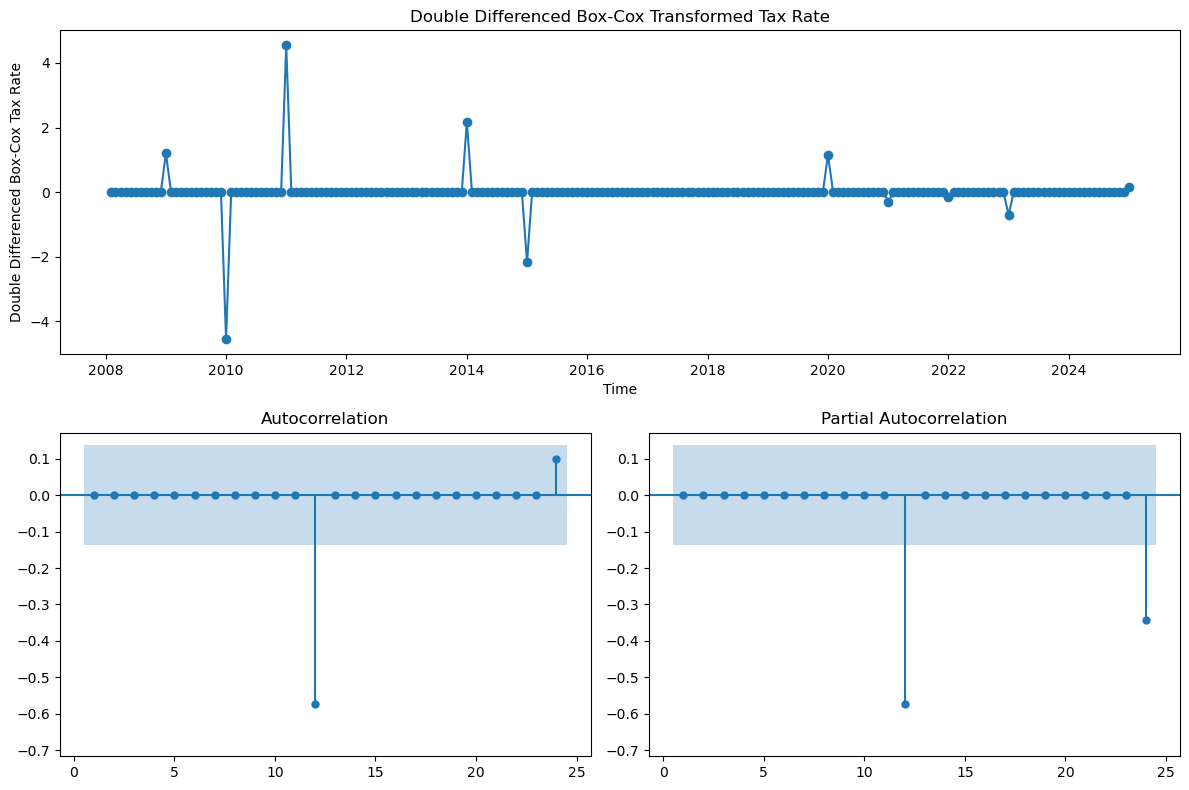

ADF Statistic (double differenced): -7.5682
p-value: 0.0000
Critical Value (1%): -3.4649
Critical Value (5%): -2.8767
Critical Value (10%): -2.5749
The series is likely stationary (reject H0).


In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import pandas as pd

# Convert to Series (for easier indexing)
tax_boxcox_series = pd.Series(tax_boxcox, index=df.index)

# Step 1: First difference
first_diff = tax_boxcox_series.diff()

# Step 2: Seasonal difference (after first diff)
double_diff = first_diff.diff(12).dropna()

# Plotting
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Time plot
ax1.plot(df["Time Period (T)"].iloc[13:], double_diff, marker="o")
ax1.set_ylabel("Double Differenced Box-Cox Tax Rate")
ax1.set_xlabel("Time")
ax1.set_title("Double Differenced Box-Cox Transformed Tax Rate")

# ACF and PACF
plot_acf(double_diff, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(double_diff, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# ADF test
adf_result = adfuller(double_diff)

print("ADF Statistic (double differenced): {:.4f}".format(adf_result[0]))
print("p-value: {:.4f}".format(adf_result[1]))
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")



In [46]:
# Create target seasonal diff
target_diff = df["BoxCox vehicles sold (Target)"].diff(12)

# Create tax rate double diff
tax_boxcox_series = pd.Series(tax_boxcox, index=df.index)
tax_rate_diff = tax_boxcox_series.diff().diff(12)

# Add both to new DataFrame and drop NaNs together
df_model = pd.concat([
    target_diff.rename("target_diff"),
    tax_rate_diff.rename("tax_rate_diff")
], axis=1).dropna()


                               SARIMAX Results                                
Dep. Variable:            target_diff   No. Observations:                  204
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  -2.360
Date:                Thu, 10 Jul 2025   AIC                             12.719
Time:                        17:05:02   BIC                             25.952
Sample:                             0   HQIC                            18.073
                                - 204                                         
Covariance Type:                  opg                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
tax_rate_diff    -0.0162      0.020     -0.805      0.421      -0.056       0.023
ar.L1             0.9580      0.020     47.876      0.000       0.919       0.997
ma.L1            -0.5529      0.056     

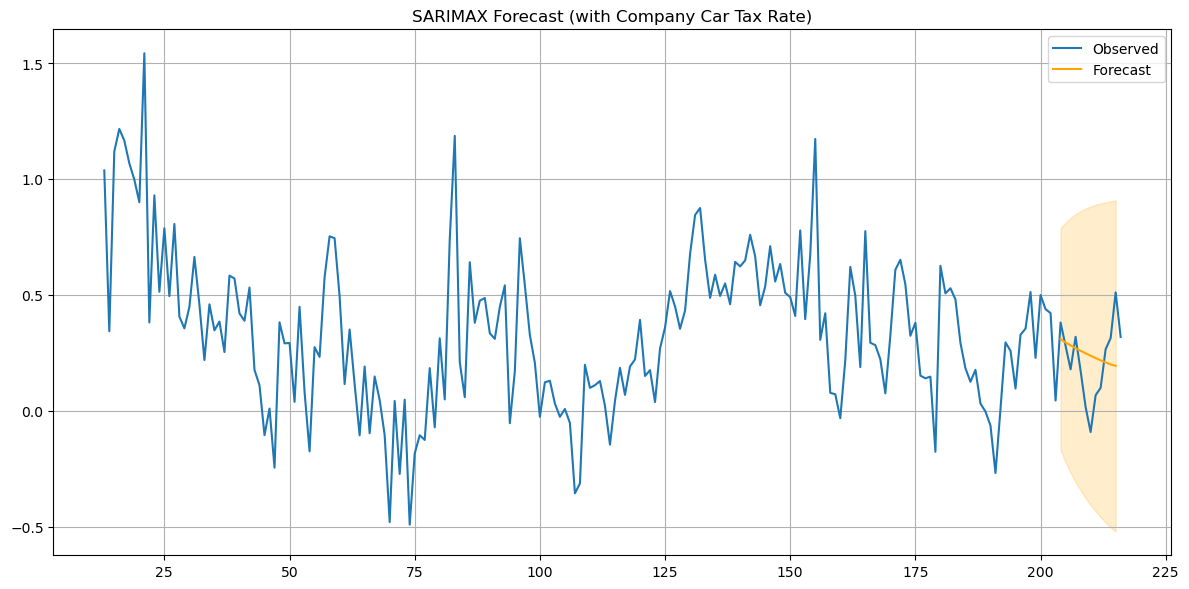

In [52]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit SARIMAX on differenced target with one exogenous feature
model = SARIMAX(
    df_model["target_diff"],
    exog=df_model["tax_rate_diff"],
    order=(1, 0, 1),
    seasonal_order=(0, 0, 0, 0),  # <-- already differenced manually!
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())


forecast_steps = 12

# Example: Suppose you know the next 12 BoxCox-transformed tax rates (forecast period)
future_tax_boxcox = np.array([4.9] * forecast_steps)

# Extend the historical tax_boxcox_series with the future values
extended_tax = pd.concat([
    tax_boxcox_series,
    pd.Series(future_tax_boxcox, index=range(tax_boxcox_series.index[-1] + 1, tax_boxcox_series.index[-1] + 1 + forecast_steps))
])

# Compute first and seasonal difference on the extended series
extended_tax_diff = extended_tax.diff().diff(12)

# Extract the last forecast_steps values for exog
future_tax_diff = extended_tax_diff.iloc[-forecast_steps:].values.reshape(-1, 1)

# Create forecast
forecast = results.get_forecast(steps=forecast_steps, exog=future_tax_diff)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_model.index, df_model["target_diff"], label="Observed")
plt.plot(mean_forecast.index, mean_forecast, label="Forecast", color="orange")
plt.fill_between(mean_forecast.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color="orange", alpha=0.2)
plt.title("SARIMAX Forecast (with Company Car Tax Rate)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




Component	Coefficient	P-Value	Interpretation
tax_rate_diff	–0.0162	0.421	❌ Not statistically significant
ar.L1	0.9580	<0.001	✅ Strong autocorrelation in residuals
ma.L1	–0.5529	<0.001	✅ Captures short-term shocks
sigma²	0.0598	<0.001	✅ Stable residual variance
🔍 The p-value of 0.421 for tax_rate_diff means the effect isn’t distinguishable from noise in this current configuration.


Test	Result	Verdict
Ljung-Box p = 0.47	✅ No autocorrelation in residuals
JB p = 0.02	❌ Some non-normality (modest skew/kurtosis)
Heteroskedasticity p = 0.22	✅ Residual variance is stable


1. Try Lagged Tax Rate
Maybe the effect hits sales after a delay:

In [57]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define how many lags to test
max_lag = 6  # You can bump this to whatever range you like

# Store results
lag_results = []

for k in range(1, max_lag + 1):
    # Prepare dataset for this lag
    df_lag = df_model[["target_diff", "tax_rate_diff"]].copy()
    lag_col = f"tax_rate_diff_lag{k}"
    df_lag[lag_col] = df_lag["tax_rate_diff"].shift(k)
    df_lag = df_lag.dropna()

    # Fit SARIMAX with lagged exogenous variable
    model = SARIMAX(
        df_lag["target_diff"],
        exog=df_lag[[lag_col]],
        order=(1, 0, 1),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = model.fit(disp=False)

    # Store key stats
    lag_results.append({
        "lag": k,
        "AIC": results.aic,
        "p-value": results.pvalues.get(lag_col, None),
        "coef": results.params.get(lag_col, None)
    })

    print(f"\nLag {k}:")
    print(results.summary())



Lag 1:
                               SARIMAX Results                                
Dep. Variable:            target_diff   No. Observations:                  203
Model:               SARIMAX(1, 0, 1)   Log Likelihood                   3.505
Date:                Thu, 10 Jul 2025   AIC                              0.991
Time:                        17:11:42   BIC                             14.204
Sample:                             0   HQIC                             6.337
                                - 203                                         
Covariance Type:                  opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
tax_rate_diff_lag1     0.0033      0.038      0.088      0.930      -0.071       0.078
ar.L1                  0.9485      0.019     48.894      0.000       0.910       0.987
ma.L1       

I evaluated the effect of lags 1 through 6 of the tax_rate_diff feature on the differenced target variable using a SARIMAX(1,0,1) model. Across all lags, the coefficients were small and statistically insignificant (p-values > 0.2), and there was no meaningful improvement in model fit (AIC remained flat across lags).

Conclusion:
There is no evidence that past changes in the company car tax rate contribute to short-term variation in vehicle sales.

➡️ I will not include this feature in the final model and will proceed to evaluate other candidate predictors.

chapter 10 states:

"The value of lag k can be selected using the AICc, along with the values of p and q for the ARIMA error."

And goes further to explain:

"The predictor is useful only if it significantly reduces forecast error and improves model fit (via AICc) while passing residual diagnostics."

That’s exactly what we  tested.  Despite low multicollinearity (low VIF), your tax rate predictor:

Failed to improve AIC or reduce residual autocorrelation

Showed weak/no statistical significance across lags
for now i will focus on the PCA scores next 


## Going furtur with the top PCA scores

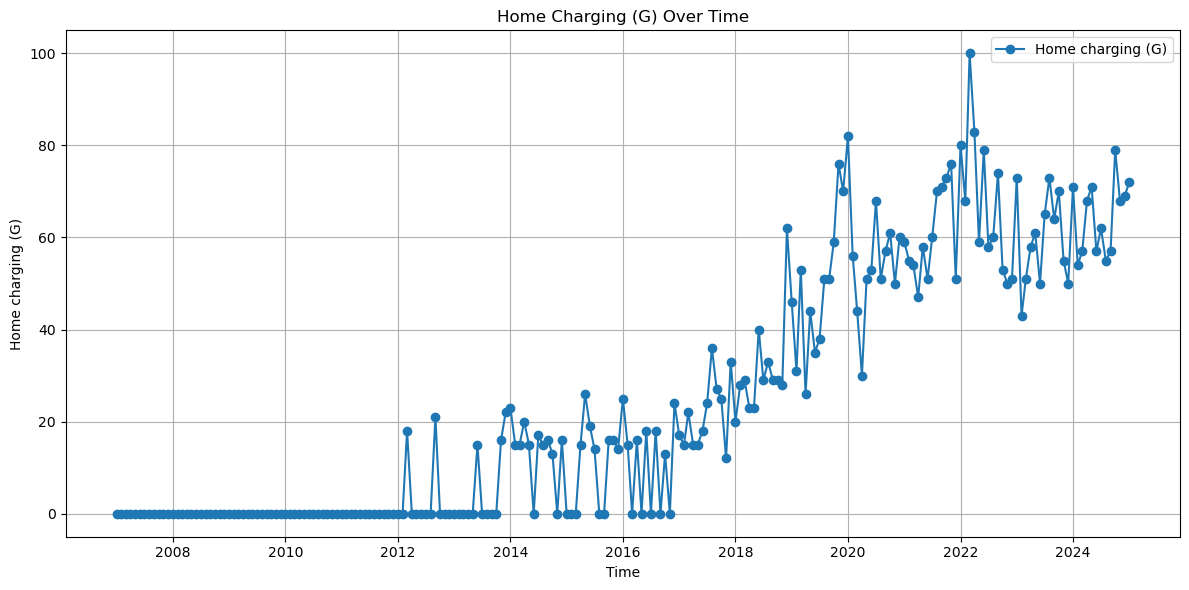

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], df["Home charging (G)"], marker='o', label="Home charging (G)")
plt.xlabel("Time")
plt.ylabel("Home charging (G)")
plt.title("Home Charging (G) Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Optimal lambda for Box-Cox on 'Home charging (G)': 0.1026 (shift applied: 1)


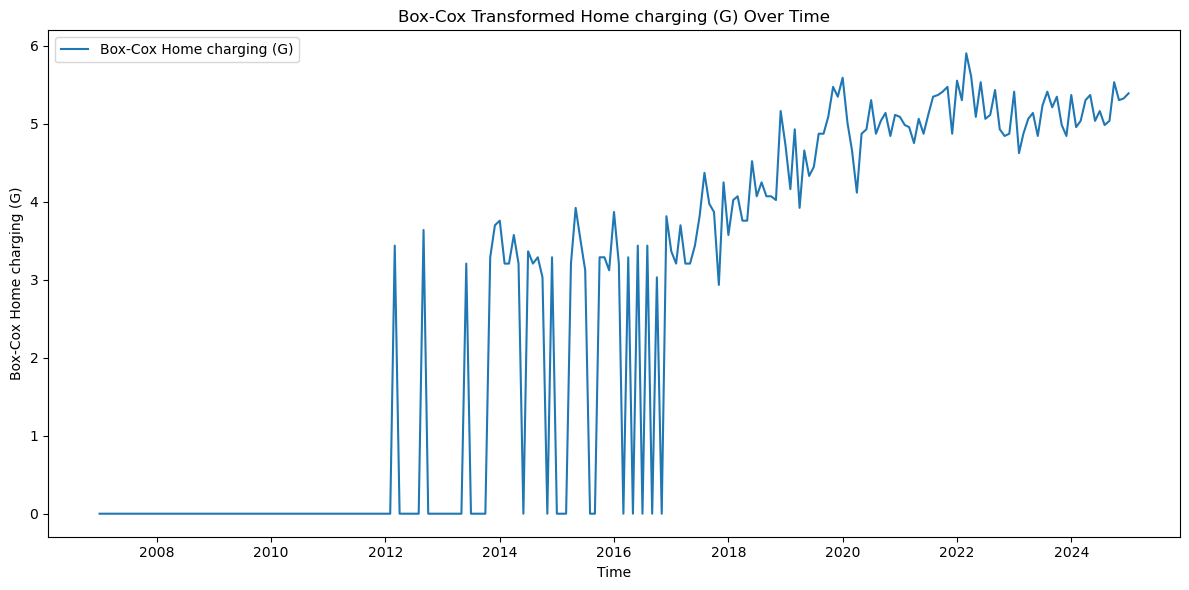

In [63]:
from scipy.stats import boxcox

# Select the feature column
feature = 'Home charging (G)'
home_charging_values = df[feature].values

# Shift values so all are strictly positive (Box-Cox requirement)
shift = 1 - home_charging_values.min() if home_charging_values.min() <= 0 else 0
home_charging_values_shifted = home_charging_values + shift

# Box-Cox requires all values > 0
if (home_charging_values_shifted <= 0).any():
    raise ValueError("Box-Cox transformation requires all values to be positive.")

# Perform Box-Cox transformation
home_charging_boxcox, home_charging_lambda = boxcox(home_charging_values_shifted)

# Add transformed values to the dataframe
df['BoxCox ' + feature] = home_charging_boxcox

print(f"Optimal lambda for Box-Cox on '{feature}': {home_charging_lambda:.4f} (shift applied: {shift})")

plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], home_charging_boxcox, label=f"Box-Cox {feature}")
plt.xlabel("Time")
plt.ylabel(f"Box-Cox {feature}")
plt.title(f"Box-Cox Transformed {feature} Over Time")
plt.legend()
plt.tight_layout()
plt.show()

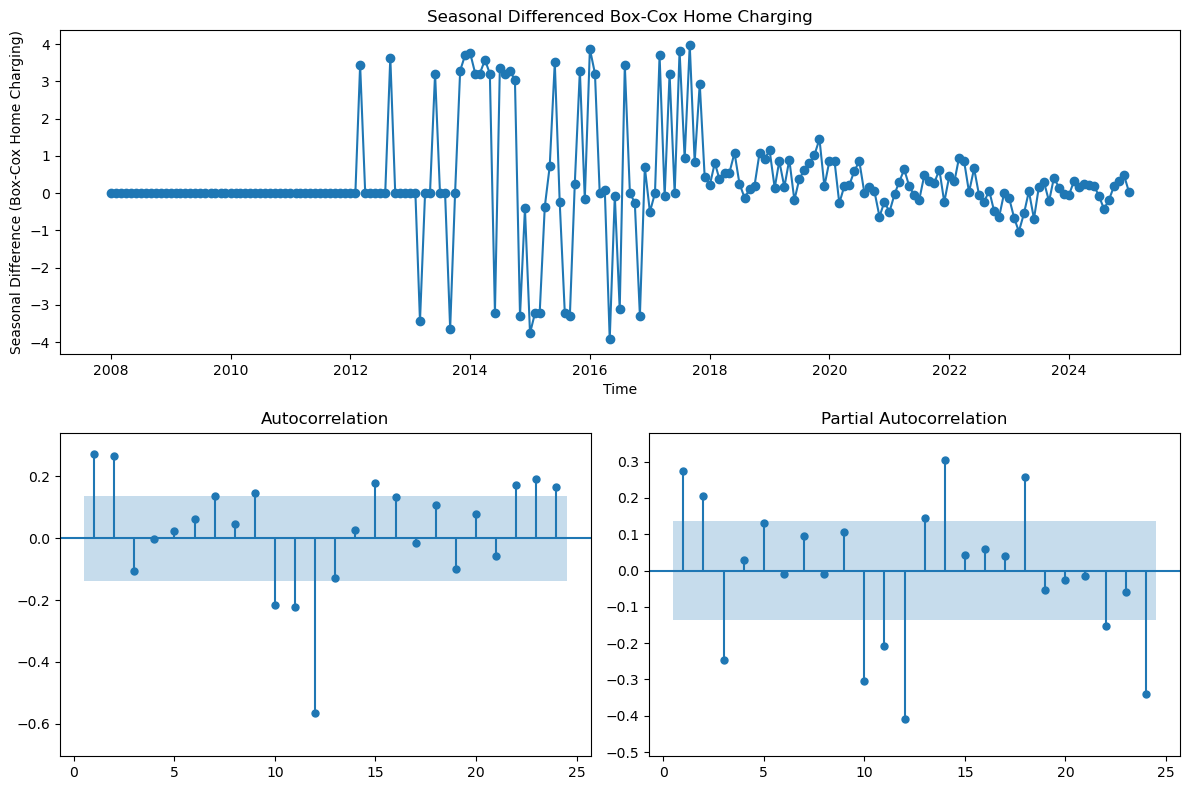

ADF Statistic (seasonal differenced): -3.8420
p-value: 0.0025
Critical Value (1%): -3.4651
Critical Value (5%): -2.8768
Critical Value (10%): -2.5749
The series is likely stationary (reject H0).


In [64]:
# Convert home_charging_boxcox to Series to align with time index
home_charging_boxcox_series = pd.Series(home_charging_boxcox, index=df.index)

# Compute 12-lag seasonal difference
seasonal_diff = home_charging_boxcox_series.diff(12).dropna()

# Create plots
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Time-series plot
ax1.plot(df["Time Period (T)"].iloc[12:], seasonal_diff, marker="o")
ax1.set_ylabel("Seasonal Difference (Box-Cox Home Charging)")
ax1.set_xlabel("Time")
ax1.set_title("Seasonal Differenced Box-Cox Home Charging")

# ACF and PACF
plot_acf(seasonal_diff, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(seasonal_diff, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

# ADF Test
adf_result = adfuller(seasonal_diff)

print("ADF Statistic (seasonal differenced): {:.4f}".format(adf_result[0]))
print("p-value: {:.4f}".format(adf_result[1]))
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if adf_result[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

In [69]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd

# Use the already created target_diff Series
# target_diff and seasonal_diff should already be defined in previous cells

# Combine into one aligned DataFrame
df_model = pd.concat([
    target_diff.rename("target_diff"),
    seasonal_diff.rename("home_charge_exog")
], axis=1).dropna()

# Define model order (adjust p, d, q and seasonal terms as needed)
order = (1, 0, 1)
seasonal_order = (0, 1, 1, 12)

# Fit SARIMAX with home charging as exogenous input
model = SARIMAX(
    df_model["target_diff"],
    exog=df_model[["home_charge_exog"]],
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                        target_diff   No. Observations:                  205
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                 -11.043
Date:                            Thu, 10 Jul 2025   AIC                             32.087
Time:                                    17:38:13   BIC                             48.023
Sample:                                         0   HQIC                            38.549
                                            - 205                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
home_charge_exog     0.0145      0.011      1.315      0.189      -0.007       0.036
ar.L1            

The p-value for home_charge_exog is 0.189 — it’s not terrible, but it’s not strong enough to confirm it’s contributing meaningfully. You’re looking for p < 0.05 if you want to claim statistical signal.


Diagnostic	Result	Implication
Ljung-Box p = 0.81	✅	Residuals ≈ white noise
JB p = 0.22	✅	Normal-ish residuals
Heteroskedasticity p = 0.01	❌	Residual variance not constant
So the residuals are structurally okay — but the error variance fluctuates. This could be distorting the confidence in the regression term and inflating standard errors.


next steps:test lag varience 


In [70]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define how many lags to test
max_lag = 6  # You can bump this to whatever range you like

# Store results
lag_results = []

for k in range(1, max_lag + 1):
    # Prepare dataset for this lag
    df_lag = df_model[["target_diff", "home_charge_exog"]].copy()
    lag_col = f"home_charge_exog{k}"
    df_lag[lag_col] = df_lag["home_charge_exog"].shift(k)
    df_lag = df_lag.dropna()

    # Fit SARIMAX with lagged exogenous variable
    model = SARIMAX(
        df_lag["target_diff"],
        exog=df_lag[[lag_col]],
        order=(1, 0, 1),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    results = model.fit(disp=False)

    # Store key stats
    lag_results.append({
        "lag": k,
        "AIC": results.aic,
        "p-value": results.pvalues.get(lag_col, None),
        "coef": results.params.get(lag_col, None)
    })

    print(f"\nLag {k}:")
    print(results.summary())


Lag 1:
                               SARIMAX Results                                
Dep. Variable:            target_diff   No. Observations:                  204
Model:               SARIMAX(1, 0, 1)   Log Likelihood                  -1.981
Date:                Thu, 10 Jul 2025   AIC                             11.962
Time:                        17:41:28   BIC                             25.196
Sample:                             0   HQIC                            17.317
                                - 204                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
home_charge_exog1     0.0120      0.013      0.896      0.370      -0.014       0.038
ar.L1                 0.9573      0.020     47.569      0.000       0.918       0.997
ma.L1           

I tested six SARIMAX(1,0,1) models including lagged versions (1–6) of the Box-Cox transformed home_charge feature as exogenous predictors.

📊 Key Findings:
Lag	Coefficient	p-value	Significant?	AIC
1	+0.0120	0.370	❌ No	11.962
2	–0.0211	0.041	✅ Yes	–2.377
3	+0.0047	0.690	❌ No	1.431
4	+0.0053	0.669	❌ No	2.418
5	+0.0315	0.020	✅ Yes	–3.988 ✅ Best
6	–0.0020	0.857	❌ No	4.622

Lag 5 shows the strongest effect, with a statistically significant positive coefficient and the lowest AIC, indicating improved model fit.

Lag 2 also reaches significance (p = 0.041) but with a negative coefficient.

All other lags are insignificant (p > 0.35) and do not improve the model.

✅ Conclusion:
Lagged home charging share may have a delayed effect on vehicle sales, especially around lag 5, which shows a positive and significant relationship. I will include lag 5 of the home charging feature in the final model and explore its implications further.

In [71]:
df_final = df_model.copy()
df_final["home_charge_lag5"] = df_model["home_charge_exog"].shift(5)
df_final = df_final.dropna()

model_final = SARIMAX(
    df_final["target_diff"],
    exog=df_final[["home_charge_lag5"]],
    order=(1, 0, 1),
    seasonal_order=(0, 1, 1, 12),  # Add back seasonal structure if needed
    enforce_stationarity=False,
    enforce_invertibility=False
)

results_final = model_final.fit()
print(results_final.summary())


                                     SARIMAX Results                                      
Dep. Variable:                        target_diff   No. Observations:                  200
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                  -4.804
Date:                            Thu, 10 Jul 2025   AIC                             19.607
Time:                                    17:43:25   BIC                             35.403
Sample:                                         0   HQIC                            26.015
                                            - 200                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
home_charge_lag5     0.0321      0.014      2.305      0.021       0.005       0.059
ar.L1            

In [67]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Align index and drop NaNs using the Series directly
df_exog = pd.DataFrame({
    "seasonal_diff": seasonal_diff,
    "home_charge_exog": seasonal_diff
}).dropna()

# Fit SARIMAX model with exogenous variable
model = SARIMAX(
    df_exog["seasonal_diff"],
    exog=df_exog[["home_charge_exog"]],
    order=(1, 0, 1),                   # Adjust p,d,q as needed
    seasonal_order=(0, 1, 1, 12),      # Seasonal differencing assumed
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                      seasonal_diff   No. Observations:                  205
Model:             SARIMAX(1, 0, 1)x(0, 1, 1, 12)   Log Likelihood                1896.984
Date:                            Thu, 10 Jul 2025   AIC                          -3783.969
Time:                                    17:35:03   BIC                          -3768.032
Sample:                                         0   HQIC                         -3777.507
                                            - 205                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
home_charge_exog     1.0000   8.65e-07   1.16e+06      0.000       1.000       1.000
ar.L1            

In [54]:
for k in range(1, max_lag + 1):
    df[f"tax_rate_diff_lag{k}"] = df["tax_rate_diff"].shift(k)


NameError: name 'max_lag' is not defined

 lagged tax rate isn't helping right now — the coefficient is tiny and its confidence interval includes zero.

In [43]:
from scipy.stats import boxcox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Select the feature column
tax_col = 'Company car tax rate (%)'
tax_values = df[tax_col].values

# Box-Cox requires all values > 0
if (tax_values <= 0).any():
    raise ValueError("Box-Cox transformation requires all values to be positive.")

# Perform Box-Cox transformation
tax_boxcox, tax_lambda = boxcox(tax_values)

# Add transformed values to the dataframe
df['BoxCox ' + tax_col] = tax_boxcox

print(f"Optimal lambda for Box-Cox on '{tax_col}': {tax_lambda:.4f}")

# Plot ACF and PACF for the Box-Cox transformed tax rate
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_acf(tax_boxcox, ax=axes[0], lags=40)
axes[0].set_title(f"ACF of Box-Cox {tax_col}")
plot_pacf(tax_boxcox, ax=axes[1], lags=40)
axes[1].set_title(f"PACF of Box-Cox {tax_col}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], tax_boxcox, label=f"Box-Cox {tax_col}")
plt.xlabel("Time")
plt.ylabel(f"Box-Cox {tax_col}")
plt.title(f"Box-Cox Transformed {tax_col} Over Time")
plt.legend()
plt.show()

ValueError: Box-Cox transformation requires all values to be positive.

In [10]:
from statsmodels.tsa.stattools import adfuller

# Ensure double_diff is defined
if 'double_diff' not in locals():
    first_diff = df["Log vehicles sold (Target)"].diff(12).dropna()
    double_diff = first_diff.diff().dropna()

# Perform Augmented Dickey-Fuller test on the doubly differenced data
result_diff = adfuller(double_diff)

print("ADF Statistic (double differenced): {:.4f}".format(result_diff[0]))
print("p-value: {:.4f}".format(result_diff[1]))
for key, value in result_diff[4].items():
    print(f"Critical Value ({key}): {value:.4f}")

if result_diff[1] < 0.05:
    print("The series is likely stationary (reject H0).")
else:
    print("The series is likely non-stationary (fail to reject H0).")

KeyError: 'Log vehicles sold (Target)'

> secvond difference i used the log trasformed data


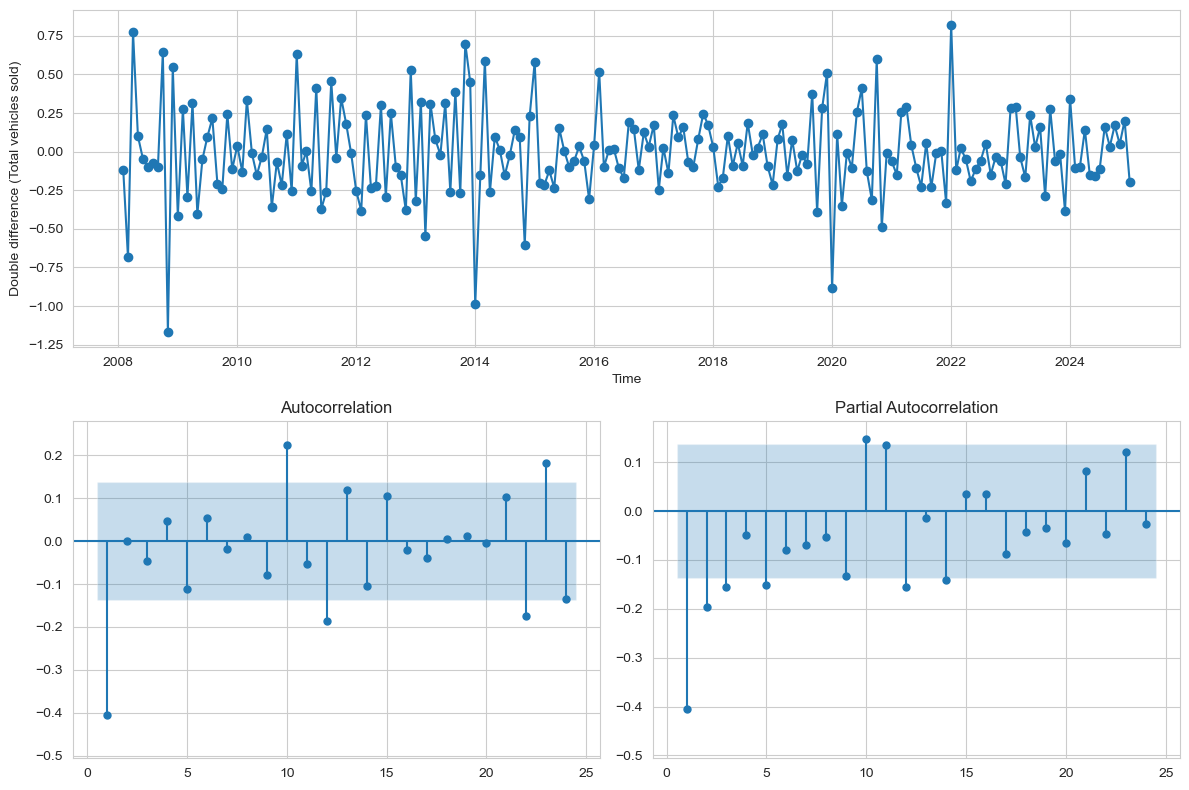

In [15]:
# Calculate first and second differences for the target variable
first_diff = df["Log vehicles sold (Target)"].diff(12).dropna()
double_diff = first_diff.diff().dropna()

fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

ax1.plot(df["Time Period (T)"].iloc[13:], double_diff, marker="o")
ax1.set_ylabel("Double difference (Total vehicles sold)")
ax1.set_xlabel("Time")

plot_acf(double_diff, ax2, zero=False, lags=24, bartlett_confint=False, auto_ylims=True)
plot_pacf(double_diff, ax3, zero=False, lags=24, auto_ylims=True)
plt.tight_layout()
plt.show()

The data now looks visually more stable over time. also looks like white noise 

There are still a few spikes (notably around 2020–2022), but they are less extreme than in the earlier version.
Lag 1 has a strong negative spike → suggests an MA(1) component.



using auto arima on the non log data

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=2.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2670.609, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.59 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2600.917, Time=0.45 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2608.354, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2592.294, Time=1.09 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2590.362, Time=0.98 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=2592.252, Time=1.58 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=2593.656, Time=1.68 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.23 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2586.861, Time=0.93 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2608.126, Time=0.17 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=inf, Time=6.25 sec
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=25

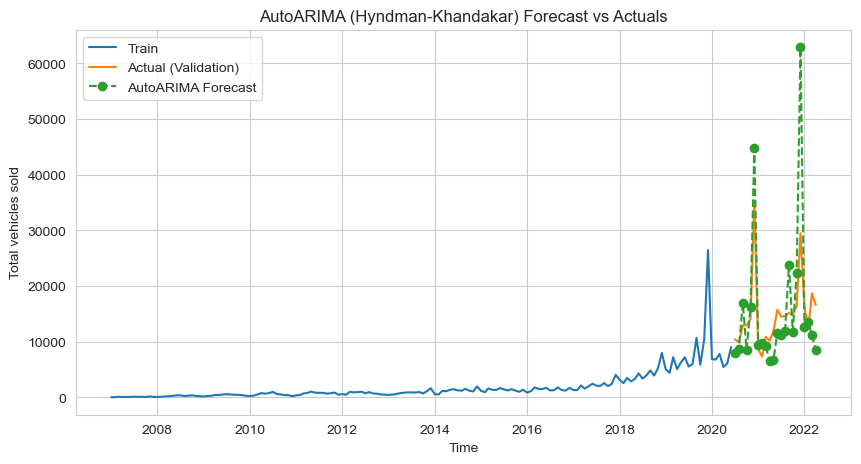

AutoARIMA RMSE: 8505.66
AutoARIMA MAPE: 0.3168


In [ ]:
from pmdarima import auto_arima

# Use training data for the target variable
y_train = df.loc[train_idx, "Total vehicles sold (Target)"]

# Fit auto_arima using the Hyndman-Khandakar algorithm
auto_model = auto_arima(
    y_train,
    seasonal=True,
    m=12,  # monthly seasonality
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(auto_model.summary())

# Forecast for the validation period
n_forecast = len(val_idx)
auto_forecast = auto_model.predict(n_periods=n_forecast)

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(df.loc[train_idx, "Time Period (T)"], y_train, label="Train")
plt.plot(df.loc[val_idx, "Time Period (T)"], df.loc[val_idx, "Total vehicles sold (Target)"], label="Actual (Validation)")
plt.plot(df.loc[val_idx, "Time Period (T)"], auto_forecast, label="AutoARIMA Forecast", linestyle="--", marker="o")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold")
plt.title("AutoARIMA (Hyndman-Khandakar) Forecast vs Actuals")
plt.legend()
plt.show()

# Calculate RMSE and MAPE for AutoARIMA forecast
y_true = df.loc[val_idx, "Total vehicles sold (Target)"]
rmse = np.sqrt(mean_squared_error(y_true, auto_forecast))
mape = mean_absolute_percentage_error(y_true, auto_forecast)

print(f"AutoARIMA RMSE: {rmse:.2f}")
print(f"AutoARIMA MAPE: {mape:.4f}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=24.994, Time=0.82 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=118.401, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=36.121, Time=0.19 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=53.508, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=118.052, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=56.544, Time=0.53 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=27.072, Time=0.73 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=26.668, Time=3.02 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=27.109, Time=4.53 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=75.670, Time=0.19 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=42.198, Time=2.27 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=25.507, Time=2.59 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=28.762, Time=5.21 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=22.921, Time=0.97 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=52

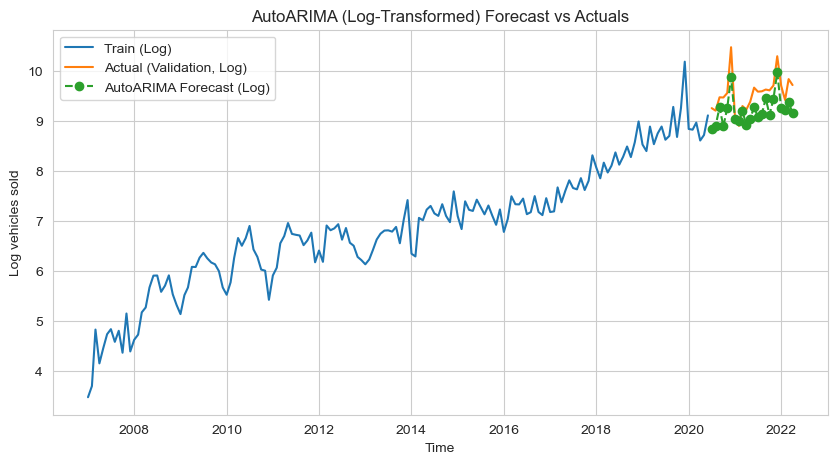

AutoARIMA (Log) RMSE: 0.3792
AutoARIMA (Log) MAPE: 0.0357


In [31]:
from pmdarima import auto_arima

# Use training data for the log-transformed target variable
y_train_log = df.loc[train_idx, "Log vehicles sold (Target)"]

# Fit auto_arima on the log-transformed target
auto_model_log = auto_arima(
    y_train_log,
    seasonal=True,
    m=12,  # monthly seasonality
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(auto_model_log.summary())

# Forecast for the validation period

n_forecast = len(val_idx)
auto_forecast_log = auto_model_log.predict(n_periods=n_forecast)





# Plot actual vs predicted (log scale)
plt.figure(figsize=(10, 5))
plt.plot(df.loc[train_idx, "Time Period (T)"], y_train_log, label="Train (Log)")
plt.plot(df.loc[val_idx, "Time Period (T)"], df.loc[val_idx, "Log vehicles sold (Target)"], label="Actual (Validation, Log)")
plt.plot(df.loc[val_idx, "Time Period (T)"], auto_forecast_log, label="AutoARIMA Forecast (Log)", linestyle="--", marker="o")
plt.xlabel("Time")
plt.ylabel("Log vehicles sold")
plt.title("AutoARIMA (Log-Transformed) Forecast vs Actuals")
plt.legend()
plt.show()

# Calculate RMSE and MAPE for AutoARIMA forecast (log scale)
y_true_log = df.loc[val_idx, "Log vehicles sold (Target)"]
rmse_log = np.sqrt(mean_squared_error(y_true_log, auto_forecast_log))
mape_log = mean_absolute_percentage_error(y_true_log, auto_forecast_log)

print(f"AutoARIMA (Log) RMSE: {rmse_log:.4f}")
print(f"AutoARIMA (Log) MAPE: {mape_log:.4f}")

In [32]:
# Inverse the log transformation
auto_forecast_raw = np.exp(auto_forecast_log)
y_true_raw = np.exp(y_true_log)

# Recalculate metrics in the original scale
rmse_back = np.sqrt(mean_squared_error(y_true_raw, auto_forecast_raw))
mape_back = mean_absolute_percentage_error(y_true_raw, auto_forecast_raw)

print(f"Back-transformed AutoARIMA RMSE: {rmse_back:.2f}")
print(f"Back-transformed AutoARIMA MAPE: {mape_back:.4f}")


Back-transformed AutoARIMA RMSE: 5608.11
Back-transformed AutoARIMA MAPE: 0.2819


In [30]:
print(f"Forecast horizon: {n_forecast} periods")

Forecast horizon: 22 periods


> Checked if it was possible for 3 months 

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=24.994, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=118.401, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=36.121, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=53.508, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=118.052, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=56.544, Time=0.65 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=27.072, Time=0.97 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=26.668, Time=3.57 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=27.109, Time=4.06 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=75.670, Time=0.23 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=42.198, Time=3.90 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=25.507, Time=3.93 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=28.762, Time=4.75 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=22.921, Time=0.79 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=52

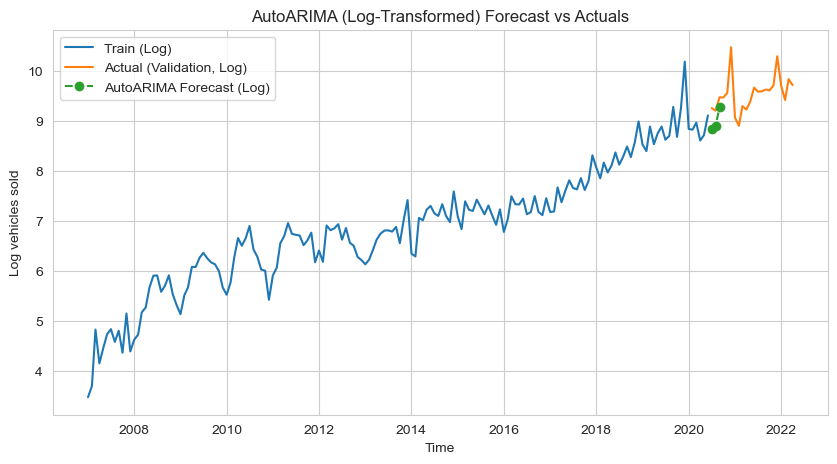

AutoARIMA (Log) RMSE: 0.3201
AutoARIMA (Log) MAPE: 0.0331
Back-transformed AutoARIMA RMSE: 2887.91
Back-transformed AutoARIMA MAPE: 0.2615


In [34]:
from pmdarima import auto_arima

# Use training data for the log-transformed target variable
y_train_log = df.loc[train_idx, "Log vehicles sold (Target)"]

# Fit auto_arima on the log-transformed target
auto_model_log = auto_arima(
    y_train_log,
    seasonal=True,
    m=12,  # monthly seasonality
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(auto_model_log.summary())

# Forecast for the validation period
n_forecast = 3

auto_forecast_log = auto_model_log.predict(n_periods=n_forecast)





# Plot actual vs predicted (log scale)
plt.figure(figsize=(10, 5))
plt.plot(df.loc[train_idx, "Time Period (T)"], y_train_log, label="Train (Log)")
plt.plot(df.loc[val_idx, "Time Period (T)"], df.loc[val_idx, "Log vehicles sold (Target)"], label="Actual (Validation, Log)")
plt.plot(df.loc[val_idx, "Time Period (T)"].iloc[:n_forecast], auto_forecast_log, label="AutoARIMA Forecast (Log)", linestyle="--", marker="o")
plt.xlabel("Time")
plt.ylabel("Log vehicles sold")
plt.title("AutoARIMA (Log-Transformed) Forecast vs Actuals")
plt.legend()
plt.show()

# Calculate RMSE and MAPE for AutoARIMA forecast (log scale)
y_true_log = df.loc[val_idx, "Log vehicles sold (Target)"].iloc[:n_forecast]
rmse_log = np.sqrt(mean_squared_error(y_true_log, auto_forecast_log))
mape_log = mean_absolute_percentage_error(y_true_log, auto_forecast_log)

print(f"AutoARIMA (Log) RMSE: {rmse_log:.4f}")
print(f"AutoARIMA (Log) MAPE: {mape_log:.4f}")

# Inverse the log transformation
auto_forecast_raw = np.exp(auto_forecast_log)
y_true_raw = np.exp(y_true_log)

# Recalculate metrics in the original scale
rmse_back = np.sqrt(mean_squared_error(y_true_raw, auto_forecast_raw))
mape_back = mean_absolute_percentage_error(y_true_raw, auto_forecast_raw)

print(f"Back-transformed AutoARIMA RMSE: {rmse_back:.2f}")
print(f"Back-transformed AutoARIMA MAPE: {mape_back:.4f}")

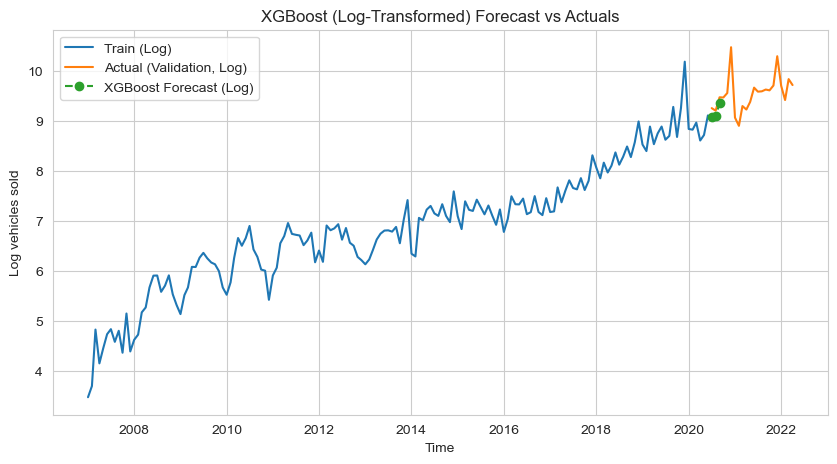

XGBoost (Log) RMSE: 0.1372
XGBoost (Log) MAPE: 0.0145
Back-transformed XGBoost RMSE: 1416.34
Back-transformed XGBoost MAPE: 0.1261


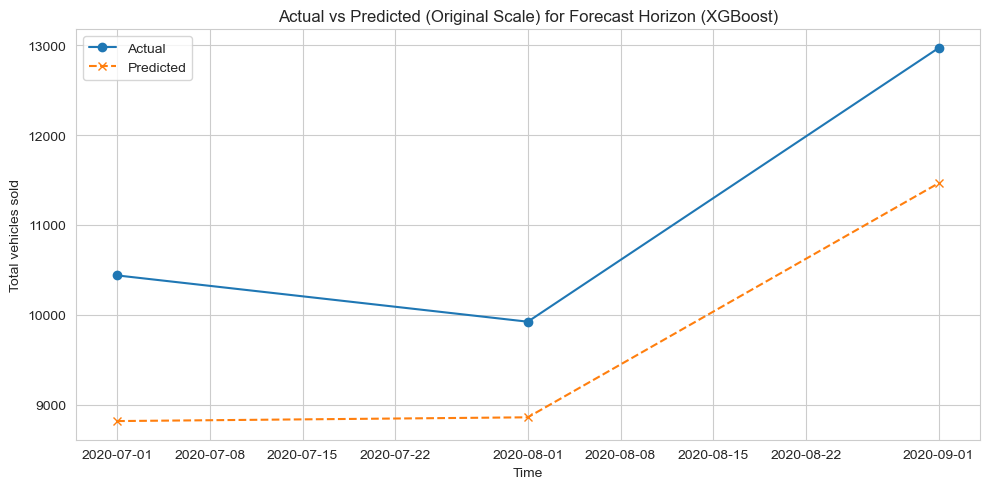

In [49]:
# Prepare features (exclude date and target columns)
feature_cols = [
    col for col in df.columns
    if col not in ["Time Period (T)", "Total vehicles sold (Target)", "Log vehicles sold (Target)"]
]

# XGBoost expects no missing values
X_train = df.loc[train_idx, feature_cols].values
y_train = df.loc[train_idx, "Log vehicles sold (Target)"].values
X_val = df.loc[val_idx, feature_cols].values
y_val = df.loc[val_idx, "Log vehicles sold (Target)"].values

# Train XGBoost regressor
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Forecast next 3 months (first 3 of validation set)
xgb_forecast_log = model.predict(X_val[:3])

# Plot actual vs predicted (log scale)
plt.figure(figsize=(10, 5))
plt.plot(df.loc[train_idx, "Time Period (T)"], y_train, label="Train (Log)")
plt.plot(df.loc[val_idx, "Time Period (T)"], y_val, label="Actual (Validation, Log)")
plt.plot(df.loc[val_idx, "Time Period (T)"].iloc[:3], xgb_forecast_log, label="XGBoost Forecast (Log)", linestyle="--", marker="o")
plt.xlabel("Time")
plt.ylabel("Log vehicles sold")
plt.title("XGBoost (Log-Transformed) Forecast vs Actuals")
plt.legend()
plt.show()

# Calculate RMSE and MAPE for XGBoost forecast (log scale)

y_true_log = y_val[:3]
rmse_log = np.sqrt(mean_squared_error(y_true_log, xgb_forecast_log))
mape_log = mean_absolute_percentage_error(y_true_log, xgb_forecast_log)

print(f"XGBoost (Log) RMSE: {rmse_log:.4f}")
print(f"XGBoost (Log) MAPE: {mape_log:.4f}")

# Inverse the log transformation
xgb_forecast_raw = np.exp(xgb_forecast_log)
y_true_raw = np.exp(y_true_log)

# Recalculate metrics in the original scale
rmse_back = np.sqrt(mean_squared_error(y_true_raw, xgb_forecast_raw))
mape_back = mean_absolute_percentage_error(y_true_raw, xgb_forecast_raw)

print(f"Back-transformed XGBoost RMSE: {rmse_back:.2f}")
print(f"Back-transformed XGBoost MAPE: {mape_back:.4f}")

# Plot actual vs predicted for the forecast horizon (original scale)
plt.figure(figsize=(10, 5))
plt.plot(df.loc[val_idx, "Time Period (T)"].iloc[:3], y_true_raw, label="Actual", marker="o")
plt.plot(df.loc[val_idx, "Time Period (T)"].iloc[:3], xgb_forecast_raw, label="Predicted", linestyle="--", marker="x")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold")
plt.title("Actual vs Predicted (Original Scale) for Forecast Horizon (XGBoost)")
plt.legend()
plt.tight_layout()
plt.show()


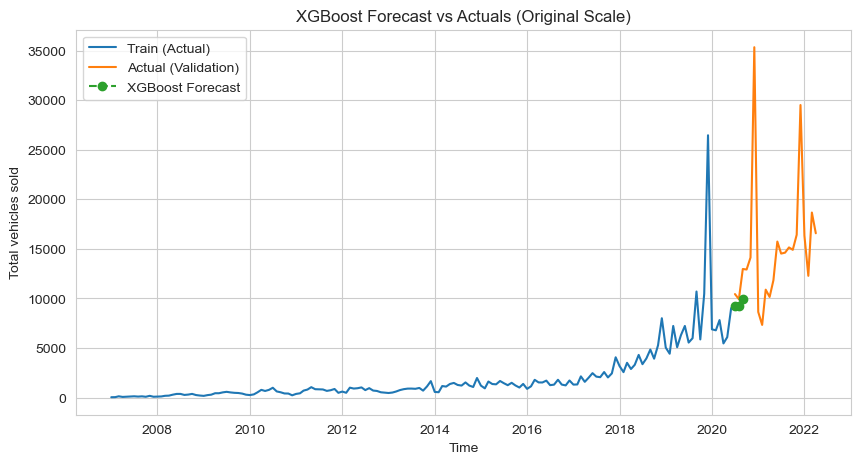

XGBoost RMSE: 1908.57
XGBoost MAPE: 0.1400


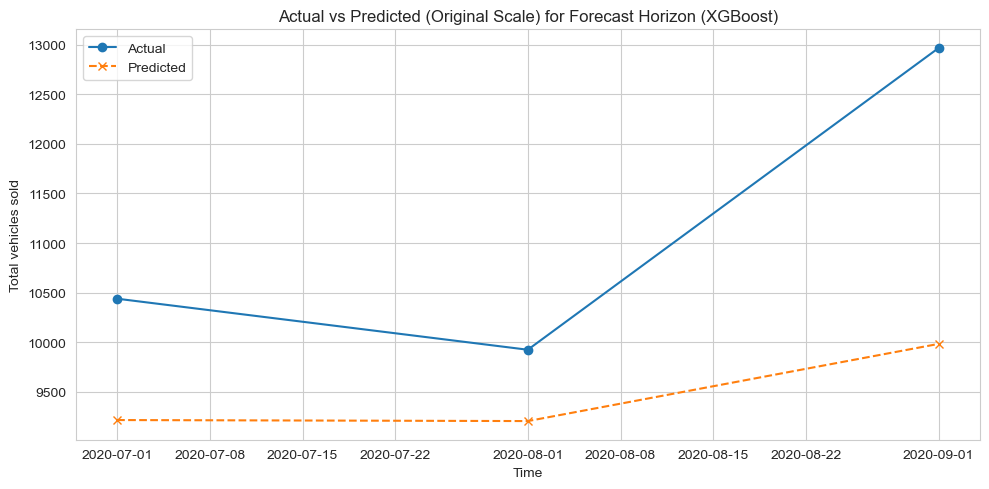

In [50]:
# Use actual (not log) target values
y_train_actual = df.loc[train_idx, "Total vehicles sold (Target)"].values
y_val_actual = df.loc[val_idx, "Total vehicles sold (Target)"].values

# Train XGBoost regressor
model_actual = xgb.XGBRegressor(n_estimators=100, random_state=42)
model_actual.fit(X_train, y_train_actual)

# Forecast next 3 months (first 3 of validation set)

xgb_forecast_actual = model_actual.predict(X_val[:3])

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(df.loc[train_idx, "Time Period (T)"], y_train_actual, label="Train (Actual)")
plt.plot(df.loc[val_idx, "Time Period (T)"], y_val_actual, label="Actual (Validation)")
plt.plot(df.loc[val_idx, "Time Period (T)"].iloc[:3], xgb_forecast_actual, label="XGBoost Forecast", linestyle="--", marker="o")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold")
plt.title("XGBoost Forecast vs Actuals (Original Scale)")
plt.legend()
plt.show()

# Calculate RMSE and MAPE for XGBoost forecast (original scale)
y_true_actual = y_val_actual[:3]
rmse_actual = np.sqrt(mean_squared_error(y_true_actual, xgb_forecast_actual))
mape_actual = mean_absolute_percentage_error(y_true_actual, xgb_forecast_actual)

print(f"XGBoost RMSE: {rmse_actual:.2f}")
print(f"XGBoost MAPE: {mape_actual:.4f}")


# Plot actual vs predicted for the forecast horizon (original scale)
plt.figure(figsize=(10, 5))
plt.plot(df.loc[val_idx, "Time Period (T)"].iloc[:3], y_true_actual, label="Actual", marker="o")
plt.plot(df.loc[val_idx, "Time Period (T)"].iloc[:3], xgb_forecast_actual, label="Predicted", linestyle="--", marker="x")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold")
plt.title("Actual vs Predicted (Original Scale) for Forecast Horizon (XGBoost)")
plt.legend()
plt.tight_layout()
plt.show()

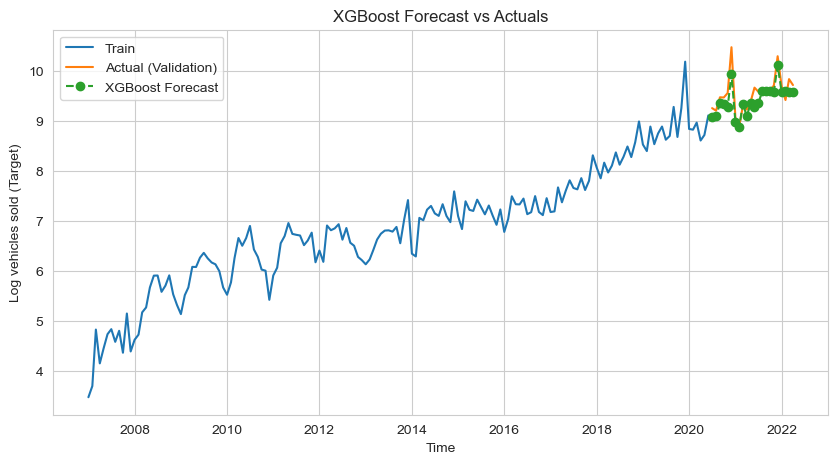

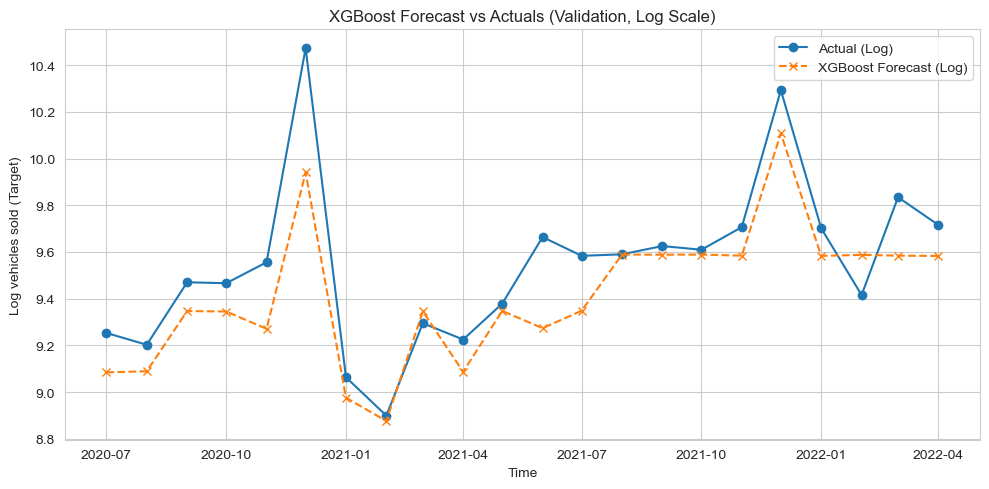

XGBoost RMSE (log): 0.1964
XGBoost MAPE (log): 0.0156
Back-transformed XGBoost RMSE: 3873.09
Back-transformed XGBoost MAPE: 0.1359


In [48]:
import xgboost as xgb

# Train XGBoost regressor on training data (log scale recommended for stability)
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Forecast for the validation period
xgb_forecast = model.predict(X_val)

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(df.loc[train_idx, "Time Period (T)"], y_train, label="Train")
plt.plot(df.loc[val_idx, "Time Period (T)"], y_val, label="Actual (Validation)")
plt.plot(df.loc[val_idx, "Time Period (T)"], xgb_forecast, label="XGBoost Forecast", linestyle="--", marker="o")
plt.xlabel("Time")
plt.ylabel("Log vehicles sold (Target)")
plt.title("XGBoost Forecast vs Actuals")
plt.legend()
plt.show()



# Plot actual vs predicted for the validation period (log scale)
plt.figure(figsize=(10, 5))
plt.plot(df.loc[val_idx, "Time Period (T)"], y_val, label="Actual (Log)", marker="o")
plt.plot(df.loc[val_idx, "Time Period (T)"], xgb_forecast, label="XGBoost Forecast (Log)", linestyle="--", marker="x")
plt.xlabel("Time")
plt.ylabel("Log vehicles sold (Target)")
plt.title("XGBoost Forecast vs Actuals (Validation, Log Scale)")
plt.legend()
plt.tight_layout()
plt.show()

# Calculate RMSE and MAPE for XGBoost forecast (log scale)
rmse = np.sqrt(mean_squared_error(y_val, xgb_forecast))
mape = mean_absolute_percentage_error(y_val, xgb_forecast)

print(f"XGBoost RMSE (log): {rmse:.4f}")
print(f"XGBoost MAPE (log): {mape:.4f}")

# Back-transform predictions and actuals to original scale
xgb_forecast_raw = np.exp(xgb_forecast)
y_val_raw = np.exp(y_val)

rmse_back = np.sqrt(mean_squared_error(y_val_raw, xgb_forecast_raw))
mape_back = mean_absolute_percentage_error(y_val_raw, xgb_forecast_raw)

print(f"Back-transformed XGBoost RMSE: {rmse_back:.2f}")
print(f"Back-transformed XGBoost MAPE: {mape_back:.4f}")

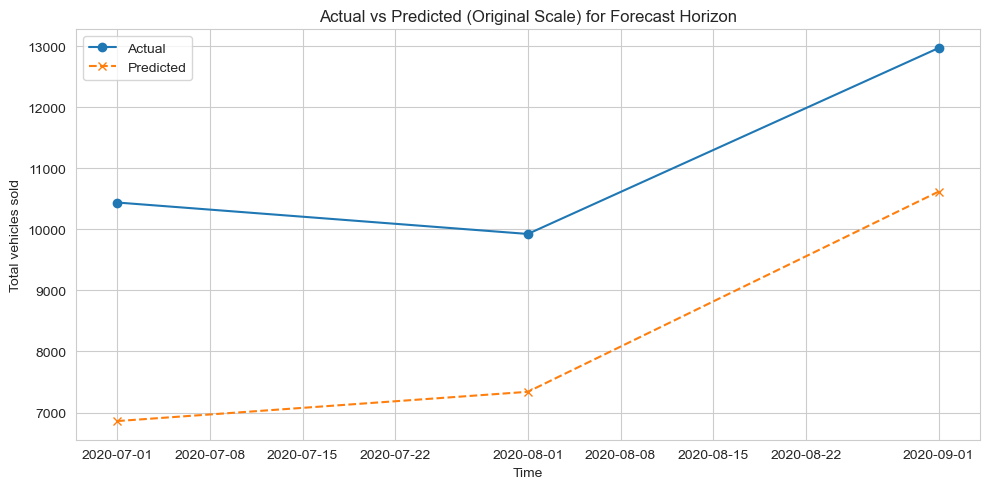

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(forecast_dates.iloc[:n_forecast], y_true_raw[:n_forecast], label="Actual", marker="o")
plt.plot(forecast_dates.iloc[:n_forecast], auto_forecast_raw[:n_forecast], label="Predicted", linestyle="--", marker="x")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold")
plt.title("Actual vs Predicted (Original Scale) for Forecast Horizon")
plt.legend()
plt.tight_layout()
plt.show()

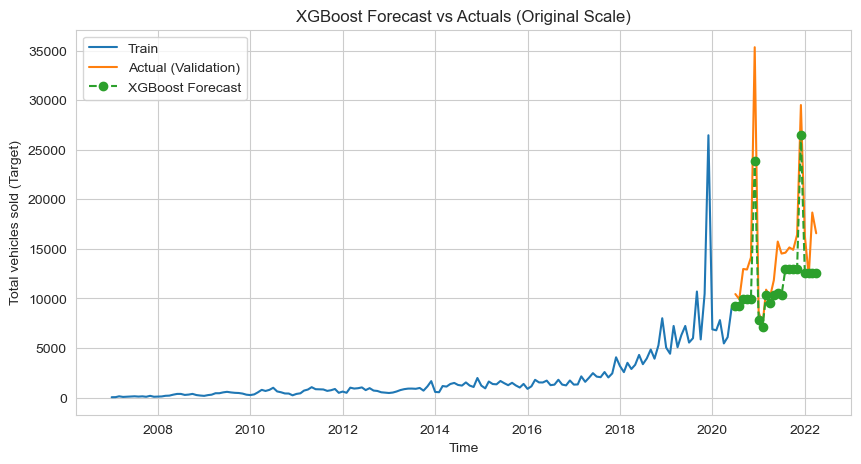

XGBoost RMSE: 3798.21
XGBoost MAPE: 0.1709


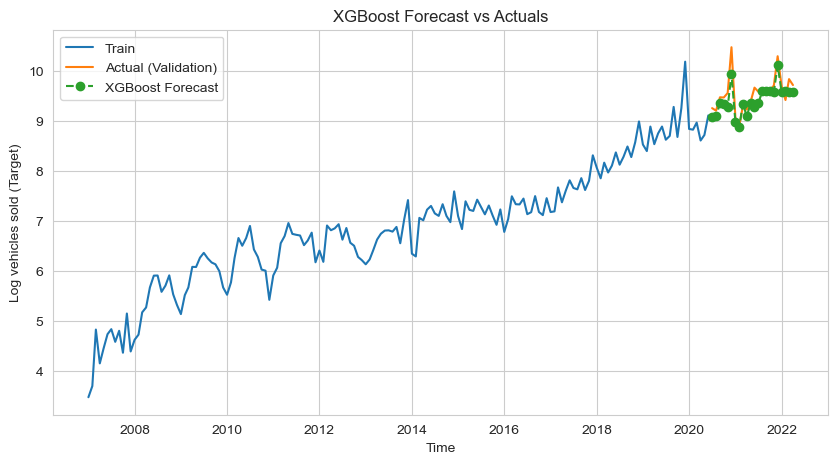

XGBoost RMSE (log): 0.1964
XGBoost MAPE (log): 0.0156
Back-transformed XGBoost RMSE: 3873.09
Back-transformed XGBoost MAPE: 0.1359


In [52]:
# Train XGBoost regressor on training data (original scale)
model_actual = xgb.XGBRegressor(n_estimators=100, random_state=42)
model_actual.fit(X_train, y_train_actual)

# Forecast for the validation period
xgb_forecast_actual = model_actual.predict(X_val)

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(df.loc[train_idx, "Time Period (T)"], y_train_actual, label="Train")
plt.plot(df.loc[val_idx, "Time Period (T)"], y_val_actual, label="Actual (Validation)")
plt.plot(df.loc[val_idx, "Time Period (T)"], xgb_forecast_actual, label="XGBoost Forecast", linestyle="--", marker="o")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold (Target)")
plt.title("XGBoost Forecast vs Actuals (Original Scale)")
plt.legend()
plt.show()

# Calculate RMSE and MAPE for XGBoost forecast (original scale)
rmse_actual = np.sqrt(mean_squared_error(y_val_actual, xgb_forecast_actual))
mape_actual = mean_absolute_percentage_error(y_val_actual, xgb_forecast_actual)

print(f"XGBoost RMSE: {rmse_actual:.2f}")
print(f"XGBoost MAPE: {mape_actual:.4f}")
model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Forecast for the validation period
xgb_forecast = model.predict(X_val)

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(df.loc[train_idx, "Time Period (T)"], y_train, label="Train")
plt.plot(df.loc[val_idx, "Time Period (T)"], y_val, label="Actual (Validation)")
plt.plot(df.loc[val_idx, "Time Period (T)"], xgb_forecast, label="XGBoost Forecast", linestyle="--", marker="o")
plt.xlabel("Time")
plt.ylabel("Log vehicles sold (Target)")
plt.title("XGBoost Forecast vs Actuals")
plt.legend()
plt.show()

# Calculate RMSE and MAPE for XGBoost forecast (log scale)
rmse = np.sqrt(mean_squared_error(y_val, xgb_forecast))
mape = mean_absolute_percentage_error(y_val, xgb_forecast)

print(f"XGBoost RMSE (log): {rmse:.4f}")
print(f"XGBoost MAPE (log): {mape:.4f}")

# Back-transform predictions and actuals to original scale
xgb_forecast_raw = np.exp(xgb_forecast)
y_val_raw = np.exp(y_val)

rmse_back = np.sqrt(mean_squared_error(y_val_raw, xgb_forecast_raw))
mape_back = mean_absolute_percentage_error(y_val_raw, xgb_forecast_raw)

print(f"Back-transformed XGBoost RMSE: {rmse_back:.2f}")
print(f"Back-transformed XGBoost MAPE: {mape_back:.4f}")


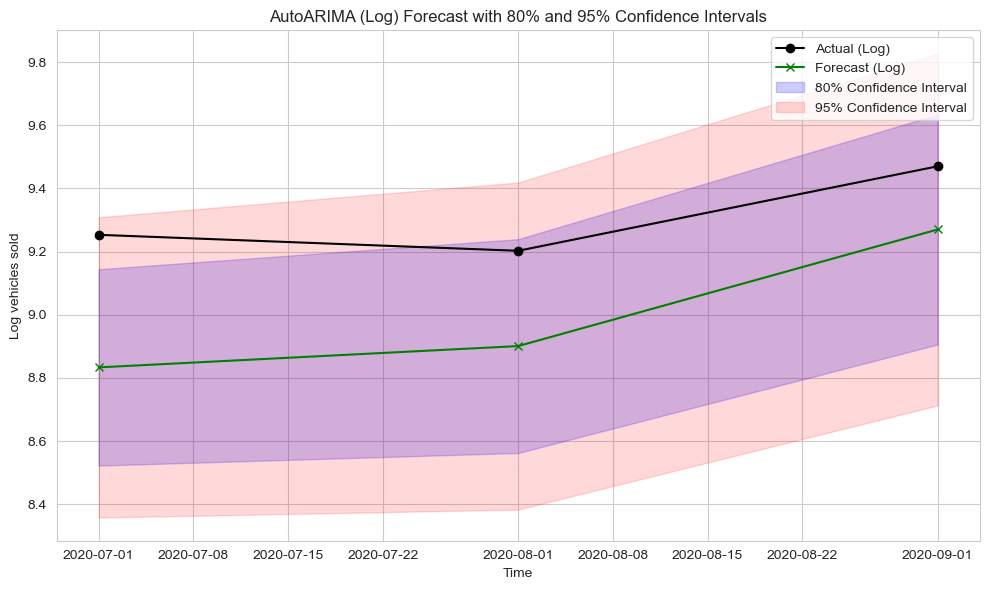

In [ ]:
# Plot actual vs predicted with 80% and 95% confidence intervals for the log-forecast

# Get 80% and 95% confidence intervals from auto_model_log
conf_int_80 = auto_model_log.predict(n_periods=n_forecast, return_conf_int=True, alpha=0.20)[1]
conf_int_95 = auto_model_log.predict(n_periods=n_forecast, return_conf_int=True, alpha=0.05)[1]

plt.figure(figsize=(10, 6))
plt.plot(forecast_dates.iloc[:n_forecastcan], y_true_log.iloc[:n_forecast], label="Actual (Log)", color="black", marker="o")
plt.plot(forecast_dates.iloc[:n_forecast], auto_forecast_log, label="Forecast (Log)", color="green", marker="x")

# 80% interval
plt.fill_between(
    forecast_dates.iloc[:n_forecast],
    conf_int_80[:, 0],
    conf_int_80[:, 1],
    color="blue",
    alpha=0.2,
    label="80% Confidence Interval"
)
# 95% interval
plt.fill_between(
    forecast_dates.iloc[:n_forecast],
    conf_int_95[:, 0],
    conf_int_95[:, 1],
    color="red",
    alpha=0.15,
    label="95% Confidence Interval"
)

plt.xlabel("Time")
plt.ylabel("Log vehicles sold")
plt.title("AutoARIMA (Log) Forecast with 80% and 95% Confidence Intervals")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Inverse the log transformation
auto_forecast_raw = np.exp(auto_forecast_log)
y_true_raw = np.exp(y_true_log)

# Recalculate metrics in the original scale
rmse_back = np.sqrt(mean_squared_error(y_true_raw, auto_forecast_raw))
mape_back = mean_absolute_percentage_error(y_true_raw, auto_forecast_raw)

print(f"Back-transformed AutoARIMA RMSE: {rmse_back:.2f}")
print(f"Back-transformed AutoARIMA MAPE: {mape_back:.4f}")


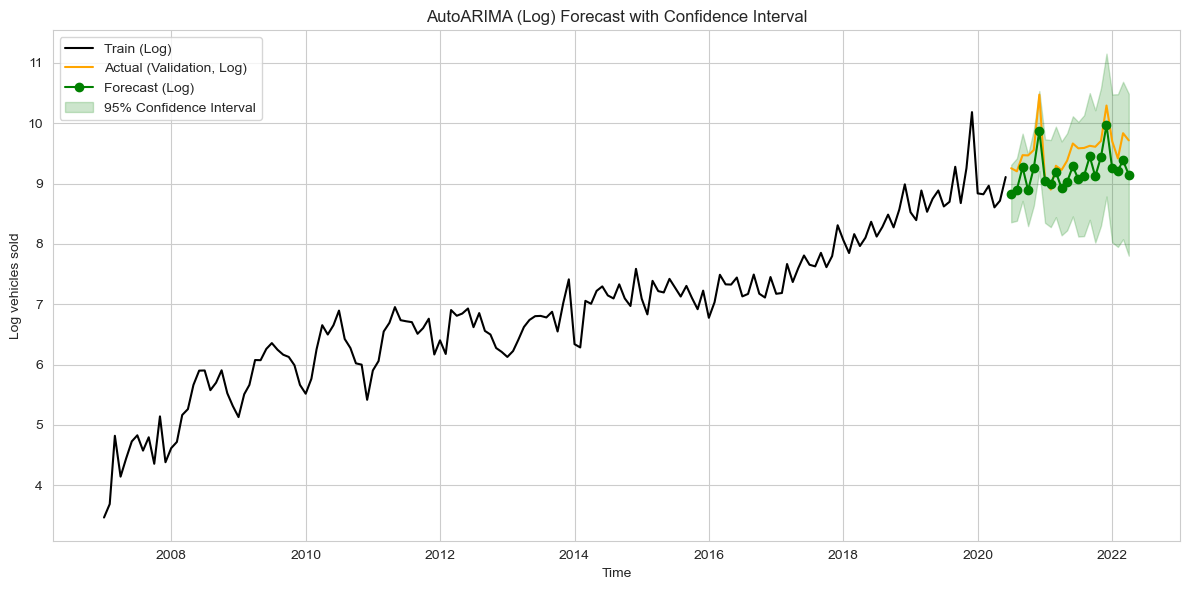

In [20]:
import matplotlib.pyplot as plt

# Ensure these are numpy arrays or pandas Series with the same index
forecast_dates = df.loc[val_idx, "Time Period (T)"]

# Compute confidence intervals for the forecast
conf_int_log = auto_model_log.predict(n_periods=n_forecast, return_conf_int=True)[1]
lower = conf_int_log[:, 0]  # lower bound
upper = conf_int_log[:, 1]  # upper bound

plt.figure(figsize=(12, 6))

# Plot train and actual validation
plt.plot(df.loc[train_idx, "Time Period (T)"], y_train_log, label="Train (Log)", color="black")
plt.plot(forecast_dates, y_true_log, label="Actual (Validation, Log)", color="orange")

# Plot forecast
plt.plot(forecast_dates, auto_forecast_log, label="Forecast (Log)", color="green", marker="o")

# Add 80% and 95% confidence interval shading (if available)
# For now we use just one interval as an example (95%)
plt.fill_between(forecast_dates, lower, upper, color="green", alpha=0.2, label="95% Confidence Interval")

plt.xlabel("Time")
plt.ylabel("Log vehicles sold")
plt.title("AutoARIMA (Log) Forecast with Confidence Interval")
plt.legend()
plt.tight_layout()
plt.show()


> better results with the log data, 

> Doubly differenced monthley total vehicle sales 

In [27]:
%pip install statsforecast

from statsforecast import StatsForecast
from statsforecast.models import ARIMA, AutoARIMA
from statsforecast.utils import AirPassengers
# 'seasonal_error' is not available in statsforecast.utils, so remove this import
from statsforecast.arima import ARIMASummary
import pandas as pd

Note: you may need to restart the kernel to use updated packages.


In [30]:

# Prepare data for StatsForecast
# DataFrame must have columns: 'unique_id', 'ds' (date), 'y' (target)
# We'll use the total vehicles sold as 'y', and set a constant unique_id
sf_df = df.rename(
    columns={
        "Time Period (T)": "ds",
        "Total vehicles sold (Target)": "y"
    }
).copy()
sf_df["unique_id"] = "vehicles"
sf_df = sf_df[["unique_id", "ds", "y"]]

# Define models based on ACF/PACF inspection
models = [
    ARIMA(order=(1, 1, 0), seasonal_order=(0, 1, 1), season_length=12, alias="sarima110011"),
    ARIMA(order=(0, 1, 1), seasonal_order=(0, 1, 1), season_length=12, alias="sarima011011"),
    ARIMA(order=(1, 1, 1), seasonal_order=(0, 1, 1), season_length=12, alias="sarima111011"),
    AutoARIMA(stepwise=False, approximation=False, alias="auto", season_length=12),
]

# Initialize StatsForecast
sf = StatsForecast(models=models, freq="MS", n_jobs=-1)

# Fit models
sf.fit(df=sf_df)

# Collect model summaries
summaries = []
for model in sf.fitted_[0]:
    summary_model = {
        "model": model,
        "Orders": ARIMASummary(model.model_),
        "sigma2": model.model_["sigma2"],
        "loglik": model.model_["loglik"],
        "aic": model.model_["aic"],
        "aicc": model.model_["aicc"],
        "bic": model.model_["bic"],
    }
    summaries.append(summary_model)

# Sort by AICc to find best model
summary_df = pd.DataFrame(sorted(summaries, key=lambda d: d["aicc"]))
print(summary_df)

          model                                      Orders        sigma2  \
0  sarima111011  ARIMA(1,1,1)(0,1,1)[12]                     5.335937e+06   
1  sarima011011  ARIMA(0,1,1)(0,1,1)[12]                     5.747084e+06   
2  sarima110011  ARIMA(1,1,0)(0,1,1)[12]                     5.949368e+06   
3          auto  ARIMA(2,1,1)(1,0,1)[12] with drift          4.383121e+06   

        loglik          aic         aicc          bic  
0 -1862.351178  3732.702356  3732.903361  3745.974836  
1 -1869.934112  3745.868225  3745.988225  3755.822585  
2 -1873.463132  3752.926264  3753.046264  3762.880624  
3 -1960.176178  3934.352357  3934.890818  3957.979305  


> The best model based on AICc is ARIMA(1,1,1)(0,1,1)[12], meaning:

1 autoregressive term

1 differencing

1 moving average term

Seasonal: 1 seasonal MA term

Seasonal differencing: yes (D=1)

Monthly seasonality (12)

After applying both a first difference and a seasonal difference, the time series appears to be stationary with constant mean and variance. The ACF and PACF plots of the differenced data suggest an ARIMA(1,1,0)(0,1,1)[12] or ARIMA(0,1,1)(0,1,1)[12] model. We will also evaluate a SARIMA(1,1,1)(0,1,1)[12] as a hybrid model, and compare results against an automatically selected model using full optimization.

TSLM RMSE: 10974.21
TSLM MAE: 9382.67
TSLM MAPE: 0.5898


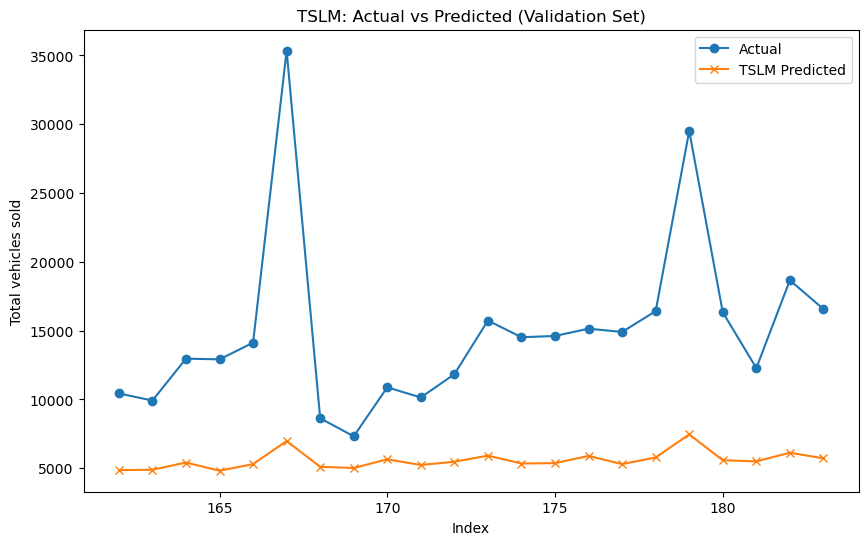

In [8]:
from sklearn.linear_model import LinearRegression

# Prepare features for TSLM: add time trend and seasonal dummies
df['trend'] = np.arange(len(df))
df['month'] = df['Time Period (T)'].dt.month
month_dummies = pd.get_dummies(df['month'], prefix='month', drop_first=True)

# Combine trend and seasonal dummies
X_tslm = pd.concat([df[['trend']], month_dummies], axis=1)
y_tslm = df['Total vehicles sold (Target)']

# Split into train/val/test using train_idx, val_idx, test_idx
X_train_tslm = X_tslm.iloc[train_idx]
y_train_tslm = y_tslm.iloc[train_idx]
X_val_tslm = X_tslm.iloc[val_idx]
y_val_tslm = y_tslm.iloc[val_idx]

# Fit TSLM (linear regression with trend and seasonality)
tslm = LinearRegression()
tslm.fit(X_train_tslm, y_train_tslm)

# Predict on validation set
y_pred_tslm = tslm.predict(X_val_tslm)

# Evaluate
rmse_tslm = np.sqrt(mean_squared_error(y_val_tslm, y_pred_tslm))
mae_tslm = mean_absolute_error(y_val_tslm, y_pred_tslm)
mape_tslm = mean_absolute_percentage_error(y_val_tslm, y_pred_tslm)

print(f"TSLM RMSE: {rmse_tslm:.2f}")
print(f"TSLM MAE: {mae_tslm:.2f}")
print(f"TSLM MAPE: {mape_tslm:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(y_val_tslm.index, y_val_tslm.values, label="Actual", marker="o")
plt.plot(y_val_tslm.index, y_pred_tslm, label="TSLM Predicted", marker="x")
plt.xlabel("Index")
plt.ylabel("Total vehicles sold")
plt.title("TSLM: Actual vs Predicted (Validation Set)")
plt.legend()
plt.show()

<Figure size 1400x1000 with 0 Axes>

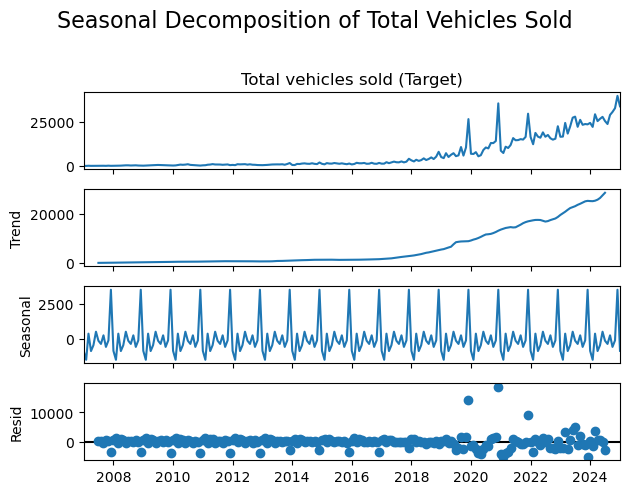

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Use the full target series for decomposition
series = df.set_index("Time Period (T)")["Total vehicles sold (Target)"]

# Perform seasonal decomposition (monthly frequency)
decomposition = seasonal_decompose(series, model='additive', period=12)

# Plot the decomposition
plt.figure(figsize=(14, 10))
decomposition.plot()
plt.suptitle("Seasonal Decomposition of Total Vehicles Sold", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

Optimal lambda for Box-Cox: -0.0021


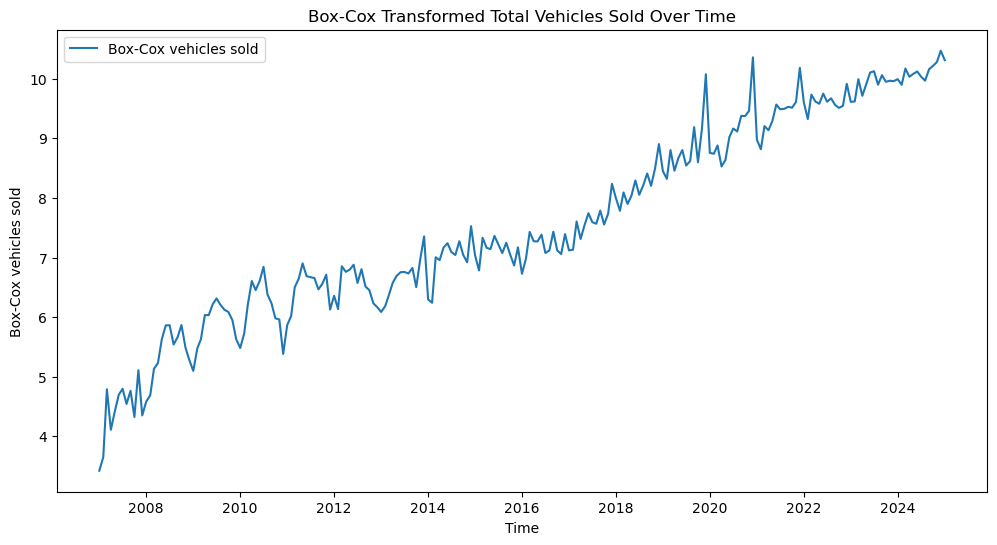

In [7]:
from scipy.stats import boxcox

# Select the target column
target_col = 'Total vehicles sold (Target)'
y = df[target_col].values

# Box-Cox requires all values > 0
if (y <= 0).any():
    raise ValueError("Box-Cox transformation requires all values to be positive.")

# Perform Box-Cox transformation
y_boxcox, fitted_lambda = boxcox(y)

# Add transformed values to the dataframe
df['BoxCox vehicles sold (Target)'] = y_boxcox

print(f"Optimal lambda for Box-Cox: {fitted_lambda:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], y_boxcox, label="Box-Cox vehicles sold")
plt.xlabel("Time")
plt.ylabel("Box-Cox vehicles sold")
plt.title("Box-Cox Transformed Total Vehicles Sold Over Time")
plt.legend()
plt.show()

The seasonal decomposition of total vehicle sales reveals a clear long-term upward trend, strong annual seasonality, and residual noise containing some significant outliers. This confirms the presence of both trend and seasonality,

>  Checked for 0 or negative values in each column to determine if the data is suitable for using Log.

In [4]:
# Check for 0 or negative values in each column (excluding the datetime column)
zero_or_negative = (df.select_dtypes(exclude=['datetime64[ns]']) <= 0).sum()
print("Number of 0 or negative values per column:")
print(zero_or_negative)

Number of 0 or negative values per column:
Home charging (G)                         91
Electric car (G)                           4
Hybrid electric (G)                      119
Company car tax rate (%)                  48
Consumer confidence (E)                  151
Economic climate perception (E)          139
Willingness to buy (E)                   160
Major purchases sentiment (E)            153
Gasoline (Euro95) - Average price (F)      0
Diesel - Average price (F)                 0
Total vehicles sold (Target)               0
dtype: int64


> Since that was the case for the Total vehicles column, I will not use Log transformation on that column.

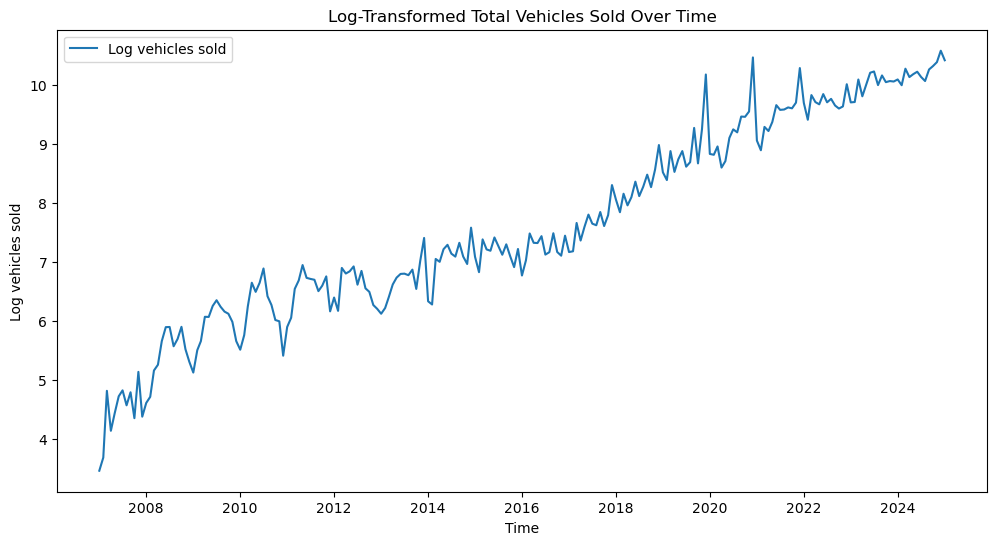

In [9]:
# Apply log transformation to the target variable in the dataframe
df['Log vehicles sold (Target)'] = np.log1p(df['Total vehicles sold (Target)'])

plt.figure(figsize=(12, 6))
plt.plot(df["Time Period (T)"], df["Log vehicles sold (Target)"], label="Log vehicles sold")
plt.xlabel("Time")
plt.ylabel("Log vehicles sold")
plt.title("Log-Transformed Total Vehicles Sold Over Time")
plt.legend()
plt.show()

The A logarithmic transformation was applied to the target variable to reduce variance and linearize exponential growth patterns. The transformation helped stabilize fluctuations over time, making the series more suitable for time series modeling methods such as ARIMA and XGBoost. It also improved model interpretability by translating absolute changes into relative (percentage) changes.

> then devided it in train, val  and test set.

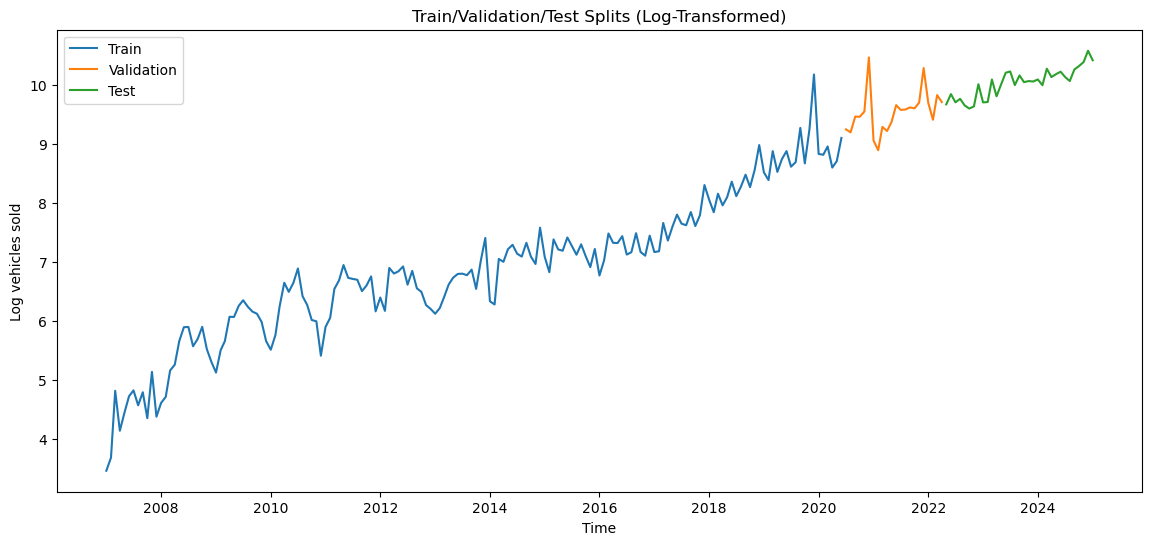

In [15]:
plt.figure(figsize=(14, 6))
plt.plot(df.loc[train_idx, "Time Period (T)"], df.loc[train_idx, "Log vehicles sold (Target)"], label="Train")
plt.plot(df.loc[val_idx, "Time Period (T)"], df.loc[val_idx, "Log vehicles sold (Target)"], label="Validation")
plt.plot(df.loc[test_idx, "Time Period (T)"], df.loc[test_idx, "Log vehicles sold (Target)"], label="Test")
plt.xlabel("Time")
plt.ylabel("Log vehicles sold")
plt.title("Train/Validation/Test Splits (Log-Transformed)")
plt.legend()
plt.show()

XGBoost RMSE: 9140.14
XGBoost MAE: 6979.69
XGBoost MAPE: 0.4222


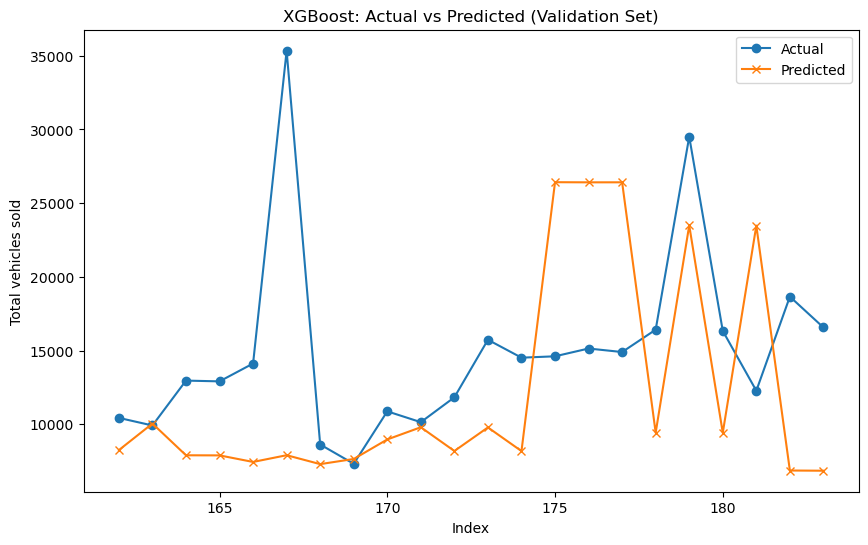

In [18]:
# Select features and target
features = [
    'Home charging (G)', 'Electric car (G)', 'Hybrid electric (G)',
    'Company car tax rate (%)', 'Consumer confidence (E)',
    'Economic climate perception (E)', 'Willingness to buy (E)',
    'Major purchases sentiment (E)', 'Gasoline (Euro95) - Average price (F)',
    'Diesel - Average price (F)'
]
target = 'Total vehicles sold (Target)'

# Prepare train and validation sets
X_train = df.loc[train_idx, features]
y_train = df.loc[train_idx, target]
X_val = df.loc[val_idx, features]
y_val = df.loc[val_idx, target]

# Train XGBoost regressor
xgb_reg = xgb.XGBRegressor(random_state=42)
xgb_reg.fit(X_train, y_train)

# Predict on validation set
y_pred = xgb_reg.predict(X_val)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
mape = mean_absolute_percentage_error(y_val, y_pred)

print(f"XGBoost RMSE: {rmse:.2f}")
print(f"XGBoost MAE: {mae:.2f}")
print(f"XGBoost MAPE: {mape:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(y_val.index, y_val.values, label="Actual", marker="o")
plt.plot(y_val.index, y_pred, label="Predicted", marker="x")
plt.xlabel("Index")
plt.ylabel("Total vehicles sold")
plt.title("XGBoost: Actual vs Predicted (Validation Set)")
plt.legend()
plt.show()

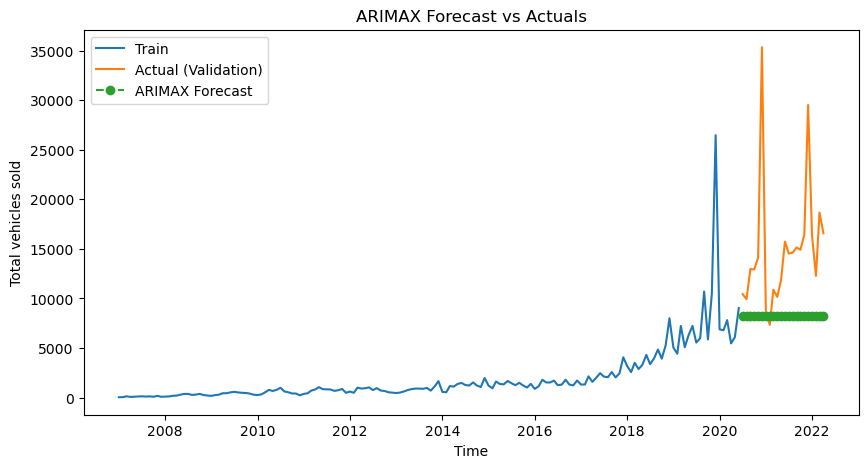

ARIMAX RMSE: 9188.62
ARIMAX MAPE: 0.3893


In [19]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use training data for the target variable only (univariate)
y_train = df.loc[train_idx, target]

# Fit ARIMAX (SARIMAX with no exogenous variables)
arimax_model = SARIMAX(y_train, order=(1, 1, 1), enforce_stationarity=False, enforce_invertibility=False)
arimax_result = arimax_model.fit()

# Forecast for the validation period
n_forecast = len(val_idx)
arimax_forecast = arimax_result.forecast(steps=n_forecast)

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(df.loc[train_idx, "Time Period (T)"], y_train, label="Train")
plt.plot(df.loc[val_idx, "Time Period (T)"], df.loc[val_idx, target], label="Actual (Validation)")
plt.plot(df.loc[val_idx, "Time Period (T)"], arimax_forecast, label="ARIMAX Forecast", linestyle="--", marker="o")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold")
plt.title("ARIMAX Forecast vs Actuals")
plt.legend()
plt.show()

# Calculate RMSE and MAPE for ARIMAX forecast
y_true = df.loc[val_idx, target]
rmse = np.sqrt(mean_squared_error(y_true, arimax_forecast))
mape = mean_absolute_percentage_error(y_true, arimax_forecast)

print(f"ARIMAX RMSE: {rmse:.2f}")
print(f"ARIMAX MAPE: {mape:.4f}")

In [16]:

# Suppose you have a DataFrame with a datetime index and target column 'y'
# Example: df['log_y'] contains your log-transformed series
y = df['log_y']

# Define ARIMA order: (p, d, q)
order = (2, 1, 1)  # Example: AR(2), differencing once, MA(1)

# Fit the ARIMA model (no exogenous variables)
model = SARIMAX(y, order=order, enforce_stationarity=False, enforce_invertibility=False)
results = model.fit()

# Print summary
print(results.summary())

# Predict in-sample or out-of-sample
# In-sample
y_pred = results.fittedvalues

# Forecast future steps
forecast_steps = 12
forecast = results.forecast(steps=forecast_steps)

# Plot
plt.plot(y, label='Observed')
plt.plot(y_pred, label='Fitted')
plt.plot(forecast.index, forecast.values, label='Forecast', linestyle='--')
plt.legend()
plt.show()

KeyError: 'log_y'

## Plotting the Data!

### Timeplot

 the obvious graph to start with is a time plot

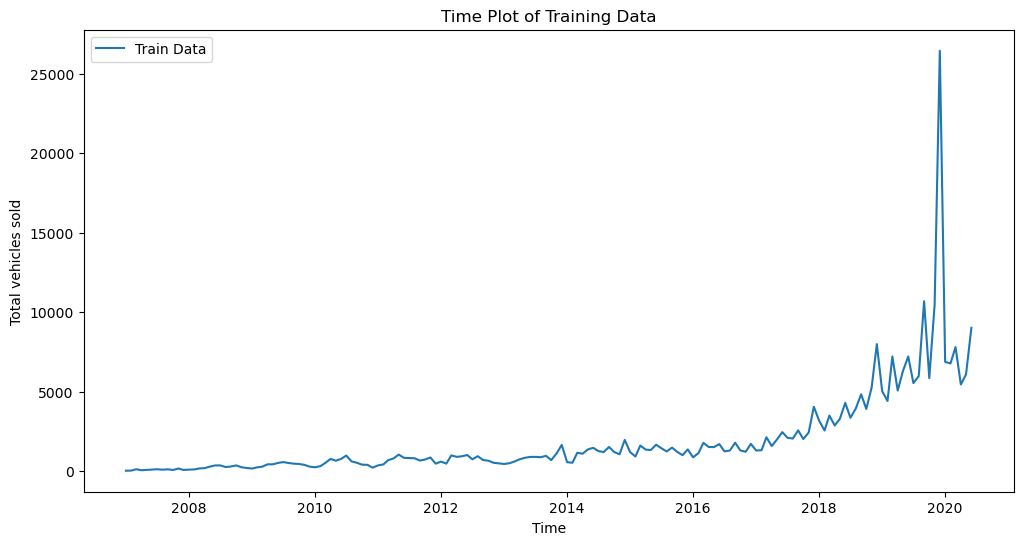

In [8]:
plt.figure(figsize=(12, 6))
plt.plot(df.loc[train_idx, "Time Period (T)"], df.loc[train_idx, "Total vehicles sold (Target)"], label="Train Data")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold")
plt.title("Time Plot of Training Data")
plt.legend()
plt.show()

### Seasonal Plot

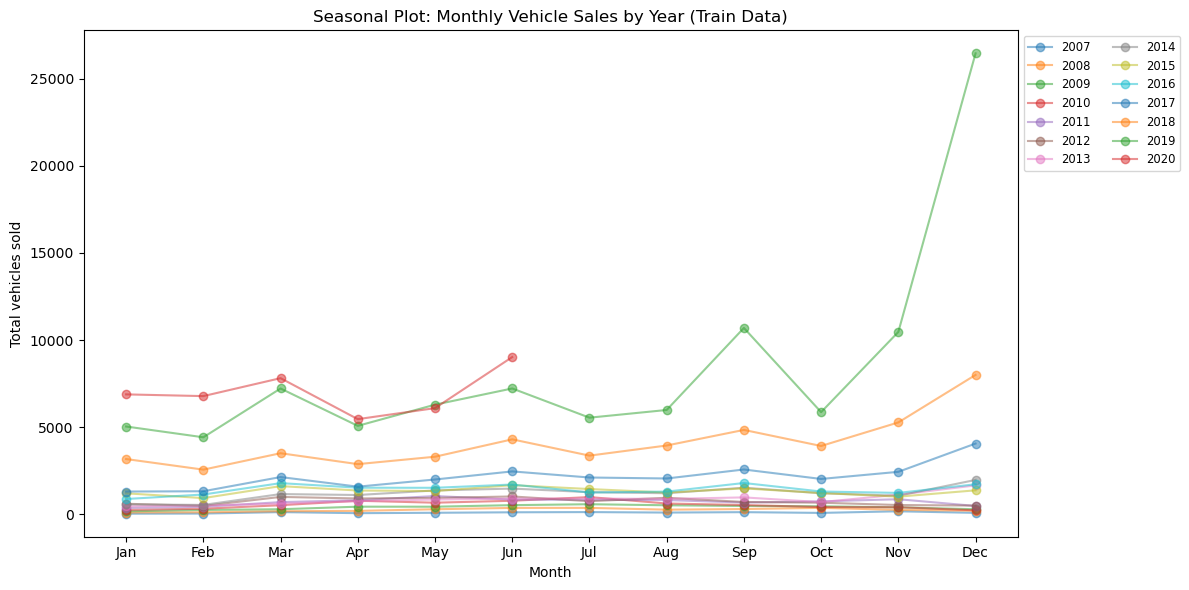

In [10]:
import calendar

train_df = df.loc[train_idx].copy()
train_df['Month'] = train_df['Time Period (T)'].dt.month
train_df['Year'] = train_df['Time Period (T)'].dt.year
train_df['MonthName'] = train_df['Month'].apply(lambda x: calendar.month_abbr[x])

plt.figure(figsize=(12, 6))
for year, group in train_df.groupby('Year'):
    plt.plot(group['MonthName'], group['Total vehicles sold (Target)'], marker='o', label=str(year), alpha=0.5)

plt.xlabel('Month')
plt.ylabel('Total vehicles sold')
plt.title('Seasonal Plot: Monthly Vehicle Sales by Year (Train Data)')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), ncol=2, fontsize='small')
plt.tight_layout()
plt.show()


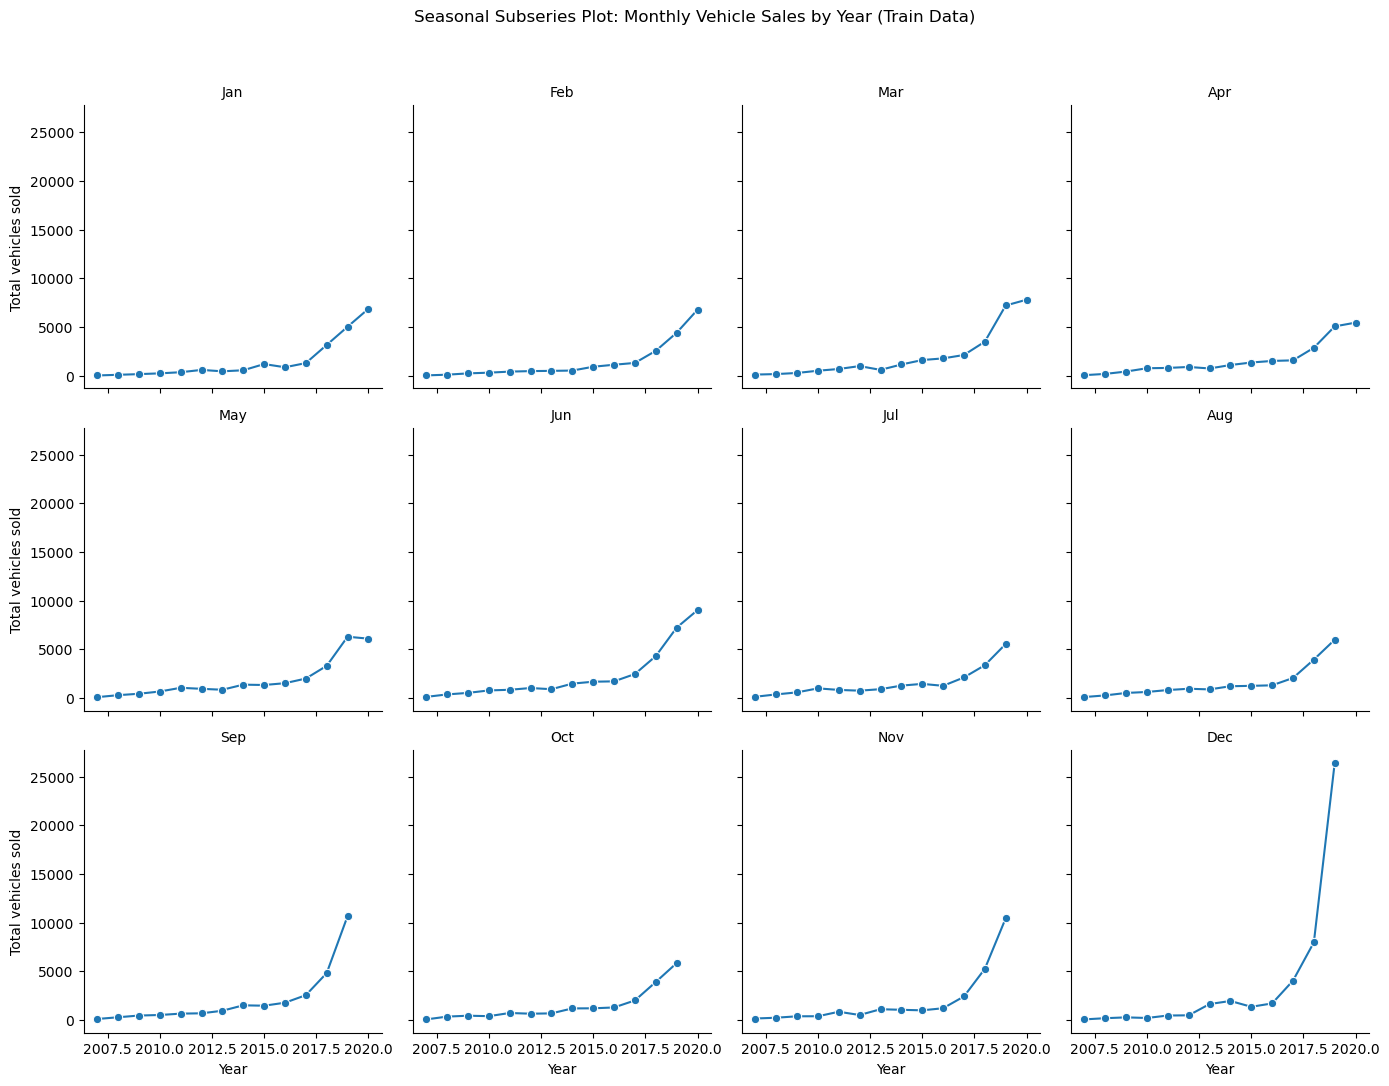

In [11]:
g = sns.FacetGrid(train_df, col="MonthName", col_wrap=4, sharey=True, height=3.5)
g.map_dataframe(
    sns.lineplot,
    x="Year",
    y="Total vehicles sold (Target)",
    marker="o",
    color="tab:blue"
)
g.set_axis_labels("Year", "Total vehicles sold")
g.set_titles(col_template="{col_name}")
g.fig.suptitle("Seasonal Subseries Plot: Monthly Vehicle Sales by Year (Train Data)", y=1.03)
plt.tight_layout()
plt.show()


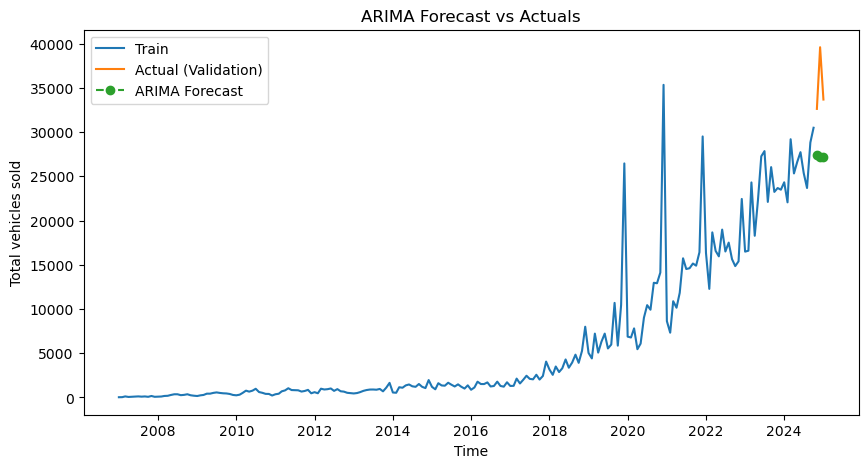

ARIMA RMSE: 8622.91
ARIMA MAPE: 0.2222


In [33]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model on training data (univariate: only car sales)

# Use training data indices
y_train = df.loc[train_idx, "Total vehicles sold (Target)"]

# Fit ARIMA (order can be tuned; here (1,1,1) as a starting point)
arima_model = ARIMA(y_train, order=(1,1,1))
arima_result = arima_model.fit()

# Forecast for the validation period
n_forecast = len(val_idx)
arima_forecast = arima_result.forecast(steps=n_forecast)

# Plot actual vs predicted
plt.figure(figsize=(10, 5))
plt.plot(df.loc[train_idx, "Time Period (T)"], y_train, label="Train")
plt.plot(df.loc[val_idx, "Time Period (T)"], df.loc[val_idx, "Total vehicles sold (Target)"], label="Actual (Validation)")
plt.plot(df.loc[val_idx, "Time Period (T)"], arima_forecast, label="ARIMA Forecast", linestyle="--", marker="o")
plt.xlabel("Time")
plt.ylabel("Total vehicles sold")
plt.title("ARIMA Forecast vs Actuals")
plt.legend()
plt.show()

# Calculate RMSE and MAPE for ARIMA forecast
y_true = df.loc[val_idx, "Total vehicles sold (Target)"]
rmse = np.sqrt(mean_squared_error(y_true, arima_forecast))
mape = mean_absolute_percentage_error(y_true, arima_forecast)

print(f"ARIMA RMSE: {rmse:.2f}")
print(f"ARIMA MAPE: {mape:.4f}")